
##  in progress logs and results
```bash
python vms_gcloud.py benchmark-instance --scp-source 'vm:/solver-benchmark/HiGHS.log' --scp-dest '../results/highs_hipo_full/{vm_name}/HiGHS.log'
python vms_gcloud.py benchmark-instance --scp-source 'vm:/solver-benchmark/results/benchmark_results.csv' --scp-dest '../results/highs_hipo_full/{vm_name}/benchmark_results.csv'
python vms_gcloud.py benchmark-instance  --scp-source 'vm:/var/log/startup-script.log' --scp-dest '../results/highs_hipo_full/{vm_name}/startup-script.log'
python vms_gcloud.py benchmark-instance  --scp-source 'vm:/var/log/startup-script.log' --scp-dest '../results/highs_hipo_full/{vm_name}/'
```
## run ids from startup-script.log

```bash
# cd solver-benchmark/results/highs_hipo_full
rg  -i 'generated.*run id' **/*.log | awk '{print $NF}
```

- 20251014_141929_benchmark-instance-standard-01
- 20251014_141943_benchmark-instance-highmem-vm-00
- 20251014_141951_benchmark-instance-standard-02
- 20251014_141939_benchmark-instance-highmem-vm-01
- 20251014_141928_benchmark-instance-standard-03
- 20251014_141941_benchmark-instance-highmem-vm-02
- 20251014_141932_benchmark-instance-standard-04
- 20251014_141958_benchmark-instance-highmem-vm-03
- 20251014_141951_benchmark-instance-standard-05
- 20251014_141941_benchmark-instance-highmem-vm-07
- 20251014_141930_benchmark-instance-standard-06
- 20251014_141930_benchmark-instance-standard-06
- 20251014_141930_benchmark-instance-standard-00

## downloading results from gcs

```bash
cd solver-benchmark/gcs-results 
gsutil cp -m -r 'gs://solver-benchmarks/results/20251014_141*' .
```


In [58]:
from pathlib import Path
import yaml
import pandas as pd
import glob
import os
import sys
import re

# Number of HiGHS variants we expect to run per benchmark
NUM_HIGHS_VARIANTS = 5


def load_results(combined_csv_path: Path):
    """
    Load results with preference for GCS (completed) over VM (in-progress) results.
    GCS results are from completed VMs that uploaded to cloud storage.
    VM results are from in-progress VMs accessed via SCP.
    """
    # Try to load from combined CSV first
    if combined_csv_path.exists():
        print(f"Loading combined results from: {combined_csv_path}")
        return pd.read_csv(combined_csv_path)

    # Otherwise, assemble from GCS and VM sources
    results_dir = combined_csv_path.parent
    vm_result_csv_files = glob.glob(str(results_dir / "*" / "benchmark_results.csv"))
    gcs_result_csv_files = glob.glob("../gcs-results/*/*.csv")

    print(f"Found {len(gcs_result_csv_files)} GCS CSV files (completed)")
    print(f"Found {len(vm_result_csv_files)} VM CSV files (in-progress)")

    all_dfs = []
    results_seen = set()

    # First, load GCS results (preferred)
    for csv_file in gcs_result_csv_files:
        df = pd.read_csv(csv_file)
        print(f"  GCS: Read {len(df)} rows from {os.path.basename(os.path.dirname(csv_file))}")
        all_dfs.append(df)
        # Mark this VM as seen
        match = re.findall(r".*(benchmark-instance.*-\d+)", str(csv_file))
        if match:
            results_seen.add(match[0])

    # Then, load VM results (only if not already in GCS)
    for csv_file in vm_result_csv_files:
        vm_name = os.path.basename(os.path.dirname(csv_file))
        # Prefer GCS results to SCP'd results
        if vm_name in results_seen:
            print(f"  VM: Skipping {vm_name} (already loaded from GCS)")
            continue
        df = pd.read_csv(csv_file)
        print(f"  VM: Read {len(df)} rows from {vm_name}")
        all_dfs.append(df)

    if not all_dfs:
        raise FileNotFoundError(f"No results CSVs found at {combined_csv_path}, GCS, or VM directories")

    print(f"\nConcatenating {len(all_dfs)} result files")
    return pd.concat(all_dfs, ignore_index=True)


def ensure_bench_size(results: pd.DataFrame):
    if "bench-size" not in results.columns:
        if "Benchmark" in results.columns and "Size" in results.columns:
            results["bench-size"] = results["Benchmark"].astype(str) + '-' + results["Size"].astype(str)
        elif "Benchmark" in results.columns:
            results["bench-size"] = results["Benchmark"].astype(str)
        elif "Size" in results.columns:
            results["bench-size"] = results["Size"].astype(str)
        else:
            results["bench-size"] = results.index.astype(str)
    return results


def parse_alloc_yaml(yaml_path: Path):
    """Return mapping bench-size -> expected info extracted from the allocation YAML."""
    with open(yaml_path) as fh:
        raw = yaml.safe_load(fh)

    vmname = yaml_path.stem
    machine_type = raw.get("machine-type") or raw.get("machine_type")

    exp_map = {}
    # Expect `benchmarks` -> benchmark_key -> { 'Sizes': [ { 'Name': <size>, '_runtime_s': <s> }, ... ] }
    for bench_key, bench_info in (raw.get("benchmarks") or {}).items():
        sizes = bench_info.get("Sizes") or []
        for s in sizes:
            name = s.get("Name") or s.get("name")
            # _base_runtime_s is the runtime for ONE variant run
            # _runtime_s is typically 5x the base (for all 5 variants)
            base_runtime_s = s.get("_base_runtime_s")
            total_runtime_s = s.get("_runtime_s") or s.get("runtime_s") or s.get("_total_runtime_s")

            # If no base_runtime_s, estimate from total (divide by 5)
            if base_runtime_s is None and total_runtime_s is not None:
                base_runtime_s = total_runtime_s / NUM_HIGHS_VARIANTS

            if name is None:
                continue
            bench_size = f"{bench_key}-{name}"
            exp_map[bench_size] = {
                "vm": vmname,
                "base_runtime_s": float(base_runtime_s) if base_runtime_s is not None else pd.NA,
                "total_runtime_s": float(total_runtime_s) if total_runtime_s is not None else pd.NA,
                "machine_type": machine_type,
                "benchmark_key": bench_key,
                "size_name": name,
            }
    return exp_map


def build_expected_map(alloc_dir: Path):
    expected = {}
    files = sorted(glob.glob(str(alloc_dir / "*.yaml")))
    if not files:
        raise FileNotFoundError(f"No allocation YAMLs found in {alloc_dir}")

    for p in files:
        path = Path(p)
        try:
            m = parse_alloc_yaml(path)
            for k, v in m.items():
                if k in expected:
                    print(f"Warning: duplicate allocation key {k} in {path}; overwriting previous entry")
                expected[k] = v
        except Exception as exc:
            print(f"Failed to parse {path}: {exc}")
    return expected


def normalize_vm_name(vm_name: str) -> str:
    """Normalize VM name by removing common prefixes to enable matching.

    Examples:
        'benchmark-instance-highmem-vm-00' -> 'highmem-vm-00'
        'benchmark-instance-standard-01' -> 'standard-01'
        'highmem-vm-00' -> 'highmem-vm-00'
    """
    if pd.isna(vm_name):
        return "<unknown>"

    vm_str = str(vm_name).strip()
    # Remove common prefixes
    prefixes = ["benchmark-instance-", "instance-"]
    for prefix in prefixes:
        if vm_str.startswith(prefix):
            vm_str = vm_str[len(prefix):]
            break
    return vm_str


def get_timeout_by_machine(runs: pd.DataFrame) -> dict:
    """Infer timeout values by machine type from actual results."""
    timeout_map = {}

    # Find VM hostname column
    vm_col = None
    vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance"}
    for c in runs.columns:
        normalized = c.lower().replace(' ', '').replace('_', '').replace('-', '')
        if normalized in vm_candidates:
            vm_col = c
            break

    if vm_col and "Timeout" in runs.columns:
        # Map hostname patterns to machine types
        for _, row in runs.iterrows():
            hostname = str(row.get(vm_col, ""))
            timeout = row.get("Timeout")

            if pd.notna(timeout):
                if "highmem" in hostname.lower():
                    timeout_map["c4-highmem-8"] = timeout
                elif "standard" in hostname.lower():
                    timeout_map["c4-standard-2"] = timeout

    return timeout_map


def summarize(expected_map: dict, runs: pd.DataFrame):
    # find vm column in runs if present
    vm_col = None
    vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance", "vm_name", "vm-hostname", "vmhostname", "vm host"}
    for c in runs.columns:
        normalized = c.lower().replace(' ', '').replace('_', '').replace('-', '')
        if normalized in vm_candidates:
            vm_col = c
            break

    # Get timeout values by machine type
    timeout_by_machine = get_timeout_by_machine(runs)

    # Prepare runs data (excluding reference benchmarks)
    runs = runs.copy()
    runs = ensure_bench_size(runs)
    actual_runs = runs[runs["Benchmark"] != "reference-benchmark"]

    # Build reverse map: bench-size -> expected VM
    bench_to_expected_vm = {bench_size: normalize_vm_name(info["vm"]) for bench_size, info in expected_map.items()}

    # Validate that benchmarks ran on their expected VMs
    misallocated_benchmarks = []
    for _, row in actual_runs.iterrows():
        bench_size = row.get("bench-size")
        if pd.isna(bench_size):
            continue

        observed_vm = normalize_vm_name(row.get(vm_col) if vm_col else pd.NA)
        expected_vm = bench_to_expected_vm.get(bench_size)

        if expected_vm and observed_vm != expected_vm:
            misallocated_benchmarks.append({
                "bench-size": bench_size,
                "expected_vm": expected_vm,
                "actual_vm": observed_vm,
                "solver": row.get("Solver"),
            })

    if misallocated_benchmarks:
        print("\n" + "="*80)
        print("ERROR: BENCHMARKS RUNNING ON UNEXPECTED VMs")
        print("="*80)
        misalloc_df = pd.DataFrame(misallocated_benchmarks)

        # Group by benchmark to show summary
        print(f"\nFound {len(misallocated_benchmarks)} variant runs on wrong VMs:")
        print(f"Affected benchmarks: {misalloc_df['bench-size'].nunique()}")
        print()

        # Show summary by expected vs actual VM
        print("Misallocation summary:")
        summary = misalloc_df.groupby(["expected_vm", "actual_vm"]).size().reset_index(name="count")
        for _, row in summary.iterrows():
            print(f"  {row['expected_vm']:20s} -> {row['actual_vm']:20s} : {row['count']} variant runs")

        print("\nSample misallocated runs:")
        for i, item in enumerate(misallocated_benchmarks[:20]):
            print(f"  {item['bench-size']:60s} expected={item['expected_vm']:20s} actual={item['actual_vm']:20s} solver={item['solver']}")

        raise ValueError(
            f"Data validation failed: {len(misallocated_benchmarks)} variant runs found on unexpected VMs. "
            f"Check allocation YAMLs vs actual benchmark execution."
        )

    # per-vm expected aggregation with timeout analysis
    per_vm_expected = {}
    for bench_size, info in expected_map.items():
        vm = normalize_vm_name(info.get("vm"))
        machine_type = info.get("machine_type")
        timeout_s = timeout_by_machine.get(machine_type, 3600.0)
        base_runtime_s = info.get("base_runtime_s", 0)

        # Determine if this benchmark will likely timeout (per variant)
        will_timeout = pd.notna(base_runtime_s) and pd.notna(timeout_s) and base_runtime_s >= timeout_s

        per_vm_expected.setdefault(vm, {
            "expected_variants": 0,  # Total variant runs expected (benchmarks × 5)
            "expected_total_s": 0.0,
            "expected_timeout_variants": 0,
            "expected_complete_variants": 0,
            "benchmarks": []
        })

        # Each benchmark expects NUM_HIGHS_VARIANTS runs
        per_vm_expected[vm]["expected_variants"] += NUM_HIGHS_VARIANTS

        if pd.notna(info.get("total_runtime_s")):
            per_vm_expected[vm]["expected_total_s"] += float(info.get("total_runtime_s") or 0.0)

        if will_timeout:
            per_vm_expected[vm]["expected_timeout_variants"] += NUM_HIGHS_VARIANTS
        else:
            per_vm_expected[vm]["expected_complete_variants"] += NUM_HIGHS_VARIANTS

        per_vm_expected[vm]["benchmarks"].append((bench_size, info, will_timeout))

    # per-vm observed aggregation (count actual runs from CSV)
    per_vm_observed = {}
    for _, row in actual_runs.iterrows():
        bench_size = row.get("bench-size")
        if pd.isna(bench_size):
            continue

        observed_vm = row.get(vm_col) if vm_col else pd.NA
        vm = normalize_vm_name(observed_vm)

        per_vm_observed.setdefault(vm, {"completed_variants": 0, "completed_runtime_s": 0.0})
        per_vm_observed[vm]["completed_variants"] += 1

        # Add runtime for this variant run
        rt = row.get("Runtime (s)")
        if pd.notna(rt):
            per_vm_observed[vm]["completed_runtime_s"] += float(rt)

    # Count completed runs per benchmark for remaining work calculation
    benchmark_run_counts = actual_runs.groupby("bench-size").size().to_dict()

    # combine into a summary table
    vms = sorted(set(list(per_vm_expected.keys()) + list(per_vm_observed.keys())))
    rows = []
    for vm in vms:
        exp = per_vm_expected.get(vm, {
            "expected_variants": 0,
            "expected_total_s": 0.0,
            "expected_timeout_variants": 0,
            "expected_complete_variants": 0
        })
        obs = per_vm_observed.get(vm, {"completed_variants": 0, "completed_runtime_s": 0.0})

        remaining_variants = exp["expected_variants"] - obs["completed_variants"]
        remaining_s = max(0.0, exp["expected_total_s"] - obs["completed_runtime_s"])

        # Calculate real remaining work (only non-timeout variants that haven't run)
        pending_timeout_variants = 0
        pending_complete_variants = 0
        pending_real_work_s = 0.0

        if vm in per_vm_expected:
            for bench_size, info, will_timeout in exp["benchmarks"]:
                # How many variants have already run for this benchmark?
                completed_for_bench = benchmark_run_counts.get(bench_size, 0)
                remaining_for_bench = NUM_HIGHS_VARIANTS - completed_for_bench

                if remaining_for_bench > 0:
                    if will_timeout:
                        pending_timeout_variants += remaining_for_bench
                    else:
                        pending_complete_variants += remaining_for_bench
                        # Calculate remaining work: (remaining variants / total variants) × total_runtime
                        if pd.notna(info.get("total_runtime_s")):
                            fraction_remaining = remaining_for_bench / NUM_HIGHS_VARIANTS
                            pending_real_work_s += float(info.get("total_runtime_s", 0)) * fraction_remaining

        rows.append({
            "vm": vm,
            "expected_variants": exp["expected_variants"],
            "expected_total_h": exp["expected_total_s"] / 3600,
            "completed_variants": obs["completed_variants"],
            "completed_runtime_h": obs["completed_runtime_s"] / 3600,
            "remaining_variants": remaining_variants,
            "remaining_expected_h": remaining_s / 3600,
            "remaining_real_work_h": pending_real_work_s / 3600,
            "pending_timeout_variants": pending_timeout_variants,
            "pending_complete_variants": pending_complete_variants,
        })

    df = pd.DataFrame(rows).sort_values("vm")

    print("\nPer-VM expected vs observed summary:")
    print(f"(Each benchmark needs {NUM_HIGHS_VARIANTS} variant runs to complete)")
    if df.empty:
        print("  (no VMs found)")
    else:
        # pretty print
        with pd.option_context('display.float_format', '{:,.1f}'.format):
            print(df.to_string(index=False))

    # Summary of pending work
    total_pending_timeout = df["pending_timeout_variants"].sum()
    total_pending_complete = df["pending_complete_variants"].sum()
    total_real_work_h = df["remaining_real_work_h"].sum()

    print(f"\nPending variant runs breakdown:")
    print(f"  Total pending variants: {total_pending_timeout + total_pending_complete}")
    print(f"  Expected to timeout: {total_pending_timeout}")
    print(f"  Expected to complete: {total_pending_complete}")
    print(f"  Real work remaining: {total_real_work_h:.1f}h (excludes timeout variants)")

    # Show some incomplete benchmarks
    print(f"\nBenchmark completion status:")
    benchmark_list = []
    for bench_size, info in expected_map.items():
        completed_variants = benchmark_run_counts.get(bench_size, 0)
        if completed_variants < NUM_HIGHS_VARIANTS:
            base_h = info.get("base_runtime_s", 0) / 3600
            machine = info.get("machine_type")
            timeout_s = timeout_by_machine.get(machine, 3600.0)
            timeout_h = timeout_s / 3600
            will_timeout = "TIMEOUT" if base_h >= timeout_h else "complete"
            benchmark_list.append((bench_size, info.get("vm"), completed_variants, will_timeout, base_h, timeout_h))

    print(f"  Total benchmarks: {len(expected_map)}")
    print(f"  Fully complete (5/5 variants): {len([b for b in benchmark_run_counts.values() if b >= NUM_HIGHS_VARIANTS])}")
    print(f"  Partially complete: {len([b for b in benchmark_run_counts.values() if 0 < b < NUM_HIGHS_VARIANTS])}")
    print(f"  Not started: {len(expected_map) - len(benchmark_run_counts)}")

    if benchmark_list:
        print(f"\nSample incomplete benchmarks:")
        for bench, vm, completed, status, base_h, timeout_h in sorted(benchmark_list):
            print(f"  - {bench:60s} ({completed}/{NUM_HIGHS_VARIANTS} variants, vm={vm}, base={base_h:5.1f}h, timeout={timeout_h:5.1f}h) [{status}]")


def main():
    repo_root = Path("../")
    combined_csv = repo_root / "results" / "highs_hipo_full" / "combined_highs_results.csv"
    alloc_dir = repo_root / "infrastructure" / "benchmarks" / "runtime_optimized"

    try:
        runs = load_results(combined_csv)
    except Exception as exc:
        print(f"Failed to load results: {exc}")
        sys.exit(1)

    runs = ensure_bench_size(runs)

    try:
        expected_map = build_expected_map(alloc_dir)
    except Exception as exc:
        print(f"Failed to build expected map from {alloc_dir}: {exc}")
        sys.exit(1)

    summarize(expected_map, runs)
main()

Loading combined results from: ../results/highs_hipo_full/combined_highs_results.csv

Per-VM expected vs observed summary:
(Each benchmark needs 5 variant runs to complete)
           vm  expected_variants  expected_total_h  completed_variants  completed_runtime_h  remaining_variants  remaining_expected_h  remaining_real_work_h  pending_timeout_variants  pending_complete_variants
highmem-vm-00                 10              86.9                   8                 44.2                   2                  42.7                    0.0                         2                          0
highmem-vm-01                 20              85.6                  16                 41.6                   4                  43.9                    0.0                         4                          0
highmem-vm-02                 20              85.5                  15                 36.3                   5                  49.2                    0.0                         5               

In [59]:
# Gather results from full run
import pandas as pd
import glob
import os
from pathlib import Path
import re

# Find all benchmark_results.csv files in the highs_hipo_full directory
results_dir = "../results/highs_hipo_full"
vm_result_csv_files = glob.glob(f"{results_dir}/*/benchmark_results.csv")
gcs_result_csv_files = glob.glob(f"../gcs-results/*/*.csv")

print(f"Found {len(vm_result_csv_files)} CSV files")

# Read and concatenate all CSV files
all_dfs = []
results_seen = set()
for csv_file in gcs_result_csv_files:
    df = pd.read_csv(csv_file)
    print(f"Read {len(df)} rows from {os.path.basename(os.path.dirname(csv_file))}")
    all_dfs.append(df)
    results_seen.add(re.findall(r".*(benchmark-instance.*-\d+)", str(csv_file))[0])

for csv_file in vm_result_csv_files:
    vm_name = os.path.basename(os.path.dirname(csv_file))
    # prefer gcs results to scp'd results before machine deletion
    if vm_name in results_seen:
        print(f"Skipping {vm_name} (already loaded from GCS)")
        continue
    df = pd.read_csv(csv_file)
    print(f"Read {len(df)} rows from {vm_name}")
    all_dfs.append(df)

# Concatenate all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Save to highs_results.csv
    output_file = Path(results_dir) / "combined_highs_results.csv"
    combined_df.to_csv(output_file, index=False)

    # Also expose as `results` for downstream cells when running this notebook interactively
    results = combined_df

    print(f"\nSuccessfully gathered {len(combined_df)} total rows")
    print(f"Saved to: {output_file}")
    print(f"\nColumns: {list(combined_df.columns)}")
    print(f"Shape: {combined_df.shape}")
    print(f"\nSolver breakdown:")
    print(combined_df['Solver'].value_counts())

    # Shared helper: ensure bench-size column exists
    def ensure_bench_size(df):
        """Add bench-size column if not present."""
        if 'bench-size' not in df.columns:
            if 'Benchmark' in df.columns and 'Size' in df.columns:
                df['bench-size'] = df['Benchmark'].astype(str) + '-' + df['Size'].astype(str)
            elif 'Benchmark' in df.columns:
                df['bench-size'] = df['Benchmark'].astype(str)
            elif 'Size' in df.columns:
                df['bench-size'] = df['Size'].astype(str)
            else:
                df['bench-size'] = df.index.astype(str)
        return df

    # Shared helper: detect VM hostname column
    def detect_vm_column(df):
        """Detect the VM hostname column name."""
        vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance", "vm_name", "vm-hostname", "vmhostname", "vm host"}
        for col in df.columns:
            normalized = col.lower().replace(' ', '').replace('_', '').replace('-', '')
            if normalized in vm_candidates:
                return col
        return None

    # Apply to results
    results = ensure_bench_size(results)
    vm_col = detect_vm_column(results)
    if vm_col:
        print(f"Detected VM hostname column: {vm_col}")

else:
    print("No data to combine")


# Compare HiGHS 1.11.x variants vs highs 1.10.0 baseline
# We'll treat each 1.11.x variant separately using the 'Solver' column so variants aren't lumped together.

# Use the already-loaded results variable
if 'results' not in globals():
    raise RuntimeError("`results` DataFrame not available. Run the data gathering cell first.")

# Extract baseline (1.10.0) results and exclude reference sizes
highs_110 = results[(results["Solver Version"] == "1.10.0") & (results["Size"] != "reference")].copy()
# Extract all 1.11.x results (may have different solver names for variants)
highs_111_all = results[results["Solver Version"].astype(str).str.startswith("1.11.0")].copy()

print(f"Found {len(highs_110)} results for highs-1.10.0")
print(f"Found {len(highs_111_all)} results for highs-1.11.x variants")

# Ensure required columns exist in both dataframes; if not, create them with pd.NA so selection never KeyErrors
required_cols = ["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
for col in required_cols:
    if col not in highs_110.columns:
        highs_110[col] = pd.NA
    if col not in highs_111_all.columns:
        highs_111_all[col] = pd.NA

# Load benchmark metadata to map (Benchmark, Size) -> Size label (S/M/L)
meta_path = Path('../results/metadata.yaml')
size_map = {}
try:
    import yaml
    with open(meta_path) as fh:
        meta = yaml.safe_load(fh)
    benchmarks_meta = meta.get('benchmarks', {}) if isinstance(meta, dict) else {}
    for bench_key, bench_info in benchmarks_meta.items():
        sizes = bench_info.get('Sizes') or []
        for s in sizes:
            name = s.get('Name')
            size_label = s.get('Size')
            if name and size_label:
                size_map[(bench_key, str(name))] = size_label
except Exception as e:
    print(f"Could not load metadata.yaml for bench-size labels: {e}")

# Prepare baseline frame keyed by bench-size
# Include Objective Value for baseline and preserve Benchmark column (we need it for metadata lookup)
baseline_df = highs_110[["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]].rename(columns={
    "Runtime (s)": "highs_1.10.0_runtime",
    "Memory Usage (MB)": "highs_1.10.0_memory",
    "Status": "highs_1.10.0_status",
    "Objective Value": "highs_1.10.0_objective"
})

# If VM column detected, include baseline VM hostname
if vm_col and vm_col in highs_110.columns:
    baseline_df = baseline_df.merge(highs_110[["bench-size", vm_col]], on="bench-size", how="left").rename(columns={vm_col: "baseline_vm_hostname"})
else:
    baseline_df["baseline_vm_hostname"] = pd.NA

# We'll iterate over each distinct Solver name in the 1.11.x set so variants are kept separate
variant_names = sorted(highs_111_all["Solver"].fillna("<unknown>").unique())
comparison_rows = []
summary_frames = []

for variant in variant_names:
    # Include Objective Value for variant runs and VM hostname if available
    # NOTE: do NOT include 'Size' here; keep Size only from baseline to avoid pandas creating Size_x/Size_y columns
    sel_cols = ["bench-size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
    if vm_col and vm_col in highs_111_all.columns:
        sel_cols.append(vm_col)

    variant_df = highs_111_all[highs_111_all["Solver"] == variant][sel_cols].rename(columns={
        "Runtime (s)": "variant_runtime",
        "Memory Usage (MB)": "variant_memory",
        "Status": "variant_status",
        "Objective Value": "variant_objective"
    })

    # If VM column present, rename it for the variant
    if vm_col and vm_col in variant_df.columns:
        variant_df = variant_df.rename(columns={vm_col: "variant_vm_hostname"})
    else:
        variant_df["variant_vm_hostname"] = pd.NA

    merged = baseline_df.merge(variant_df, on="bench-size", how="inner")
    if len(merged) == 0:
        continue

    # add variant name for grouping and clarity
    merged["variant_solver"] = variant

    # Map bench-size label (S/M/L) using metadata; try some normalization fallbacks
    def _lookup_size_label(row):
        bench = row.get('Benchmark')
        size_name = row.get('Size')
        if pd.notna(bench) and pd.notna(size_name):
            # try direct match
            key = (bench, str(size_name))
            if key in size_map:
                return size_map[key]
            # try underscore/dash variants and lowercase variants
            alt_keys = [
                (bench.replace('_', '-'), str(size_name)),
                (bench.replace('-', '_'), str(size_name)),
                (bench.lower(), str(size_name)),
                (bench.lower().replace('_', '-'), str(size_name)),
                (bench.lower().replace('-', '_'), str(size_name)),
            ]
            for k in alt_keys:
                if k in size_map:
                    return size_map[k]
        return pd.NA

    merged["bench_size_label"] = merged.apply(_lookup_size_label, axis=1)

    # Compute metrics: speedup (baseline / variant), absolute time diff and memory diff
    # Protect against division by zero / missing runtimes
    merged["runtime_speedup"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] / r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) and r["variant_runtime"] != 0 else pd.NA, axis=1)
    merged["runtime_diff_seconds"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] - r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) else pd.NA, axis=1)
    merged["memory_diff_mb"] = merged.apply(lambda r: (r["highs_1.10.0_memory"] - r["variant_memory"]) if pd.notna(r["highs_1.10.0_memory"]) and pd.notna(r["variant_memory"]) else pd.NA, axis=1)

    # Compute objective difference when available (baseline - variant)
    def _calc_obj_diff(row):
        try:
            if pd.notna(row.get("highs_1.10.0_objective")) and pd.notna(row.get("variant_objective")):
                return row["highs_1.10.0_objective"] - row["variant_objective"]
        except Exception:
            return pd.NA
        return pd.NA

    merged["objective_diff"] = merged.apply(_calc_obj_diff, axis=1)

    # Keep only rows where both runs succeeded for 'better/worse' classification
    both_ok = (merged["highs_1.10.0_status"] == "ok") & (merged["variant_status"] == "ok")
    merged_ok = merged[both_ok].copy()

    # Sort by speedup magnitude
    merged_ok = merged_ok.sort_values("runtime_speedup", ascending=False)

    # Save per-variant CSVs (better/worse relative to baseline). Include bench-size and objective columns in outputs
    variant_better = merged_ok[merged_ok["runtime_speedup"] > 1.0].copy()
    variant_worse = merged_ok[merged_ok["runtime_speedup"] < 1.0].copy()

    out_cols = [
        # Baseline group
        "bench-size",
        "Benchmark",
        "Size",
        "bench_size_label",
        "highs_1.10.0_runtime",
        "highs_1.10.0_memory",
        "highs_1.10.0_objective",
        "highs_1.10.0_status",
        "baseline_vm_hostname",
        # Variant group
        "variant_solver",
        "variant_runtime",
        "variant_memory",
        "variant_objective",
        "variant_status",
        "variant_vm_hostname",
        # Diffs / derived
        "runtime_speedup",
        "runtime_diff_seconds",
        "memory_diff_mb",
        "objective_diff",
    ]

    # Sort outputs by bench-size for readability
    if not variant_better.empty:
        variant_better = variant_better.sort_values("bench-size")
    if not variant_worse.empty:
        variant_worse = variant_worse.sort_values("bench-size")

    if len(variant_better) > 0:
        variant_better.to_csv(f"../hipo_better_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_better.columns])
    if len(variant_worse) > 0:
        variant_worse.to_csv(f"../hipo_worse_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_worse.columns])

    # keep for combined summary (include all merged rows, not only ok ones)
    summary_frames.append(merged)

# Combine all variant comparisons into a single dataframe for overview
if summary_frames:
    comparison_df = pd.concat(summary_frames, ignore_index=True)
    # sort combined overview by bench-size as well
    if 'bench-size' in comparison_df.columns:
        comparison_df = comparison_df.sort_values("bench-size")
    print(f"Combined comparison dataframe shape: {comparison_df.shape}")
else:
    comparison_df = pd.DataFrame()
    print("No matching benchmarks found between baseline and 1.11.x variants.")

# Show aggregate better/worse counts per variant (only where both succeeded)
if not comparison_df.empty:
    both_ok_mask = (comparison_df["highs_1.10.0_status"] == "ok") & (comparison_df["variant_status"] == "ok")
    agg = comparison_df[both_ok_mask].groupby("variant_solver")["runtime_speedup"].agg(["count", "mean", "median"]).rename(columns={"count": "matched_count"})
    print("\nPer-variant summary (matched runs only):")
    print(agg.round(3))

    # Save combined overview CSV
    # Include bench-size and objective columns
    cols_for_overview = [
        # Baseline group first
        "bench-size",
        # "Benchmark",
        # "Size",
        "bench_size_label",
        "variant_solver",
        "highs_1.10.0_status",
        "variant_status",
        "baseline_vm_hostname",
        "variant_vm_hostname",
        "highs_1.10.0_runtime",
        "variant_runtime",
        "runtime_diff_seconds",
        "runtime_speedup",
        "highs_1.10.0_memory",
        "variant_memory",
        "memory_diff_mb",
        "highs_1.10.0_objective",
        "variant_objective",
        "objective_diff",
    ]

    comparison_df.to_csv("../hipo_comparison_all_variants.csv", index=False, columns=[c for c in cols_for_overview if c in comparison_df.columns])
# End of comparison cell

Found 12 CSV files
Read 10 rows from 20251014_141944_benchmark-instance-highmem-vm-04
Read 96 rows from 20251014_141928_benchmark-instance-standard-03
Read 96 rows from 20251014_141929_benchmark-instance-standard-01
Read 105 rows from 20251014_141930_benchmark-instance-standard-00
Read 9 rows from 20251014_141959_benchmark-instance-highmem-vm-06
Read 92 rows from 20251014_141951_benchmark-instance-standard-05
Read 101 rows from 20251014_141951_benchmark-instance-standard-02
Read 119 rows from 20251014_141932_benchmark-instance-standard-04
Read 101 rows from 20251014_141930_benchmark-instance-standard-06
Read 10 rows from 20251014_141958_benchmark-instance-highmem-vm-03
Read 16 rows from benchmark-instance-highmem-vm-00
Read 27 rows from benchmark-instance-highmem-vm-02
Skipping benchmark-instance-standard-03 (already loaded from GCS)
Skipping benchmark-instance-standard-01 (already loaded from GCS)
Skipping benchmark-instance-standard-04 (already loaded from GCS)
Skipping benchmark-ins

## How do HiGHS variants compare?

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [61]:
# Color map for HiGHS variants and other solvers
color_map = {
    "highs": "#43BF94",  # green - baseline
    "highs-binary": "#2D8A63",  # darker green
    "highs-hipo": "#F66C49",  # red/orange - primary HIPO variant
    "highs-hipo-ipm": "#F9A826",  # orange
    "highs-hipo-32": "#3B82F6",  # blue
    "highs-hipo-64": "#7C3AED",  # purple
    "highs-hipo-128": "#8B5CF6",  # lighter purple
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#9333EA",  # purple
    "gurobi": "#DC2626",  # bright red
    "scip": "#0EA5E9",  # sky blue
}


def plot_single_benchmark_comparison(df, benchmark_name, figsize=(10, 6)):
    """Plot a single benchmark with solvers on x-axis.

    Args:
        df: DataFrame with benchmark results
        benchmark_name: The bench-size to plot
        figsize: Figure size tuple
    """
    # Filter to single benchmark
    bench_data = df[df["bench-size"] == benchmark_name].copy()

    if len(bench_data) == 0:
        print(f"No data found for benchmark: {benchmark_name}")
        return

    # Remove old solver versions if multiple versions exist
    bench_data = bench_data.sort_values(["Solver", "Solver Release Year"]).drop_duplicates(["Solver"], keep="last")

    # Identify successful vs failed runs
    bench_data["Success"] = bench_data["Status"] == "ok"

    # Find fastest successful solver
    successful_data = bench_data[bench_data["Success"]]
    if len(successful_data) == 0:
        print(f"No successful runs for benchmark: {benchmark_name}")
        return

    fastest_runtime = successful_data["Runtime (s)"].min()

    # Calculate slowdown for successful runs only
    bench_data.loc[bench_data["Success"], "Slowdown"] = bench_data.loc[bench_data["Success"], "Runtime (s)"] / fastest_runtime

    # For failed runs, don't calculate slowdown (will plot differently)
    bench_data.loc[~bench_data["Success"], "Slowdown"] = 0

    # Sort: successful runs by slowdown, then failed runs
    bench_data = bench_data.sort_values(["Success", "Slowdown"], ascending=[False, True])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Separate successful and failed data
    slowdowns = []
    colors_list = []

    for _, row in bench_data.iterrows():
        if row["Success"]:
            slowdowns.append(row["Slowdown"])
            colors_list.append(color_map.get(row["Solver"], "#888888"))
        else:
            slowdowns.append(0)  # Don't show bar for failed runs
            colors_list.append((color_map.get(row["Solver"], "#888888"), 0.2))

    # Create bars
    bars = ax.bar(range(len(bench_data)), slowdowns, color=colors_list)

    # Add horizontal line at y=1
    ax.axhline(1, color="grey", linestyle="--", linewidth=1, alpha=0.7)

    # Calculate max slowdown for positioning failed labels
    max_slowdown = bench_data[bench_data["Success"]]["Slowdown"].max() if len(successful_data) > 0 else 1

    # Add value labels on bars
    for i, (_, row) in enumerate(bench_data.iterrows()):
        if row["Success"]:
            label = f"{row['Slowdown']:.2f}x\n{naturaldelta(row['Runtime (s)'])}"
            y_pos = row["Slowdown"] + max_slowdown * 0.02
            color = "black"
            weight = "normal"
        else:
            # For non-ok status, show the actual status value
            label = str(row["Status"])
            y_pos = max_slowdown * 0.5  # Position in middle of plot area
            color = "red"
            weight = "bold"

        ax.text(i, y_pos, label,
                ha="center", va="bottom" if row["Success"] else "center",
                fontsize=10 if not row["Success"] else 9,
                color=color, weight=weight)

    # Set x-axis to solver names
    ax.set_xticks(range(len(bench_data)))
    ax.set_xticklabels(bench_data["Solver"], rotation=45, ha="right")

    # Labels and title
    ax.set_xlabel("Solver", fontsize=11)
    ax.set_ylabel("Relative Runtime (normalized to fastest)", fontsize=11)
    ax.set_title(f"Solver Performance Comparison\n{benchmark_name}", fontsize=12, weight="bold")

    # Add grid for easier reading
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add some padding at the top for labels
    ax.set_ylim(0, max_slowdown * 1.15)

    plt.tight_layout()

    return fig, ax

In [62]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions if multiple versions exist
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)

### All Benchmarks Comparison

In [63]:
# Filter out reference benchmarks
actual_benchmarks = results[results["Benchmark"] != "reference-benchmark"].copy()
print(actual_benchmarks.columns)

# Get unique benchmark-size combinations
unique_benchmarks = actual_benchmarks["bench-size"].unique()

# print(f"Found {len(unique_benchmarks)} unique benchmarks:")
# for b in sorted(unique_benchmarks):
#     print(f"  - {b}")

Index(['Benchmark', 'Size', 'Solver', 'Solver Version', 'Solver Release Year',
       'Status', 'Termination Condition', 'Runtime (s)', 'Memory Usage (MB)',
       'Objective Value', 'Max Integrality Violation', 'Duality Gap',
       'Reported Runtime (s)', 'Timeout', 'Hostname', 'Run ID', 'Timestamp',
       'bench-size'],
      dtype='object')


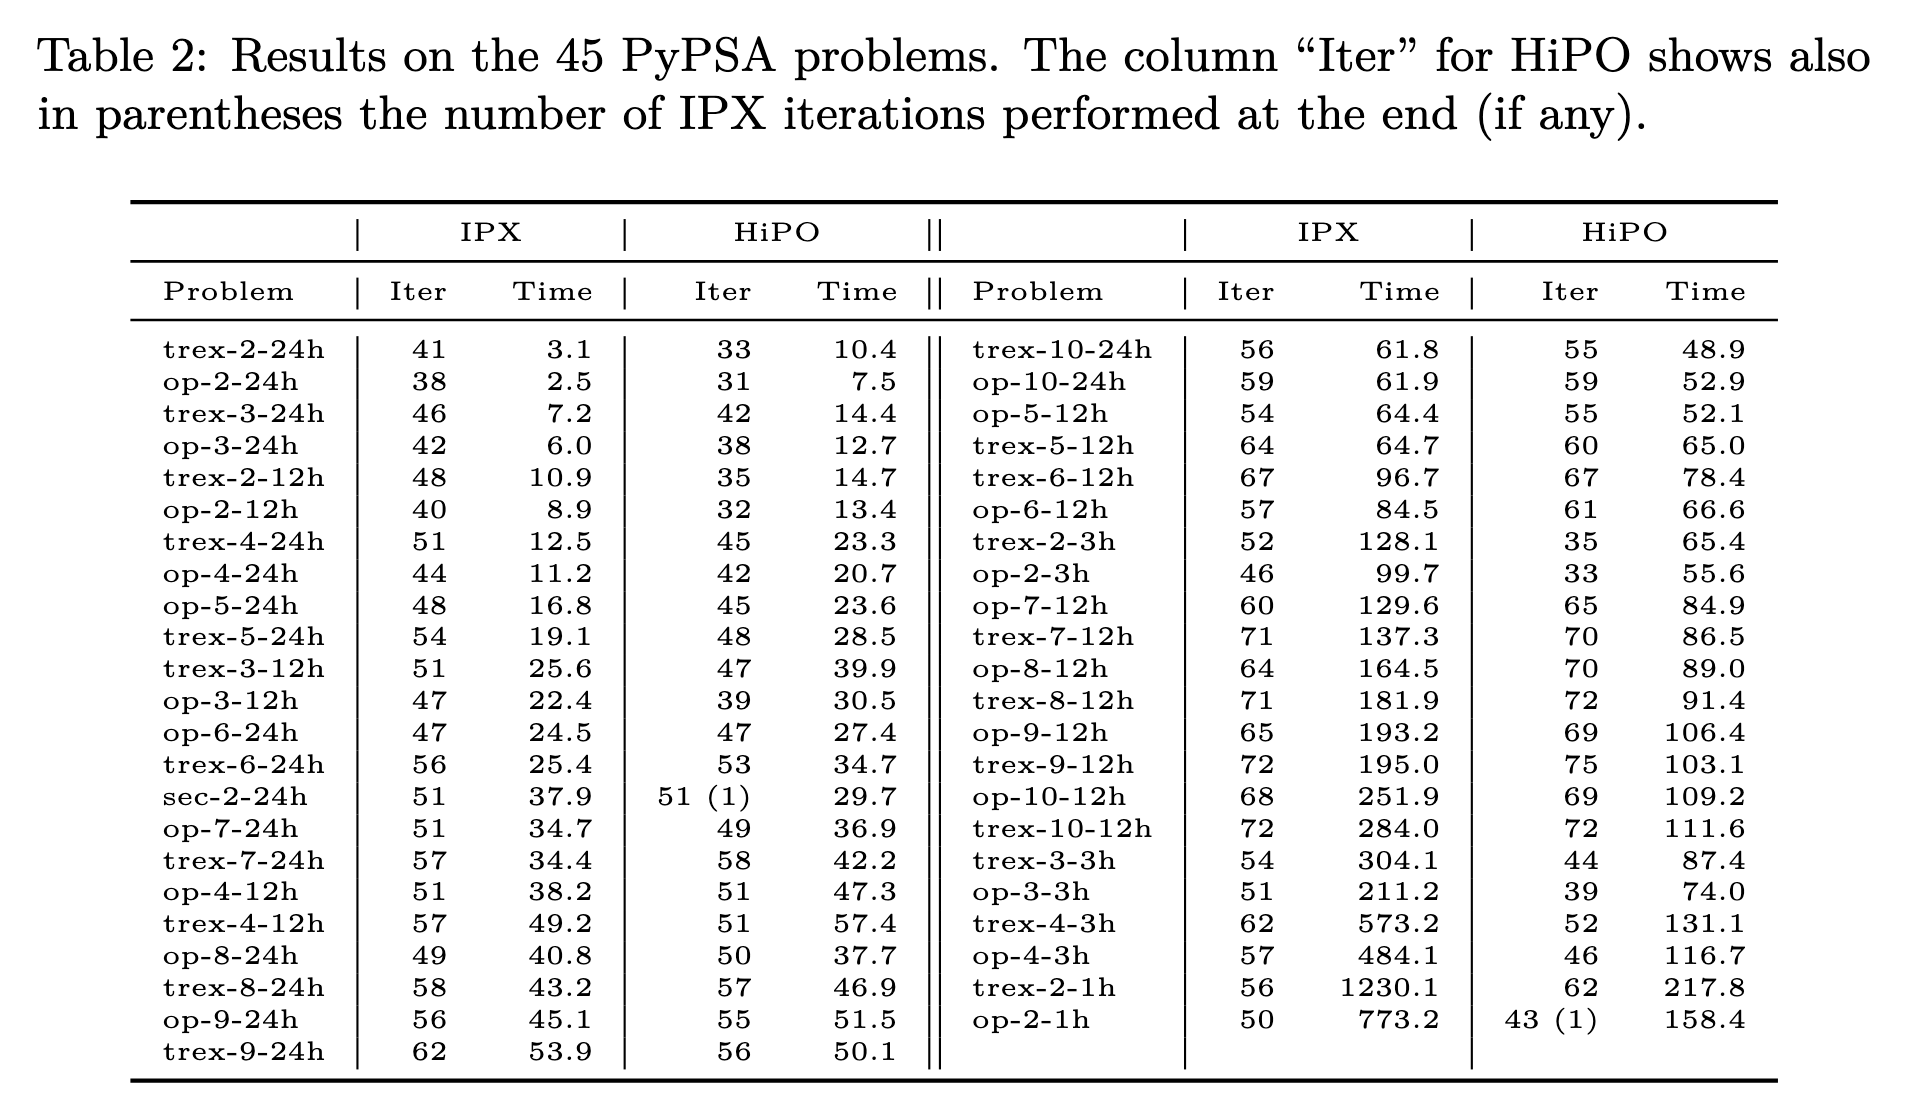


COMPARISON WITH HIPO PAPER RESULTS

Benchmark: pypsa-eur-elec-op-2-1h
Paper results - IPX (baseline): 773.2s, HiPO: 158.4s, Speedup: 4.88x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.36x, Diff vs paper: -2.52x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.09x, Diff vs paper: -2.80x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.08x, Diff vs paper: -2.80x (worse)



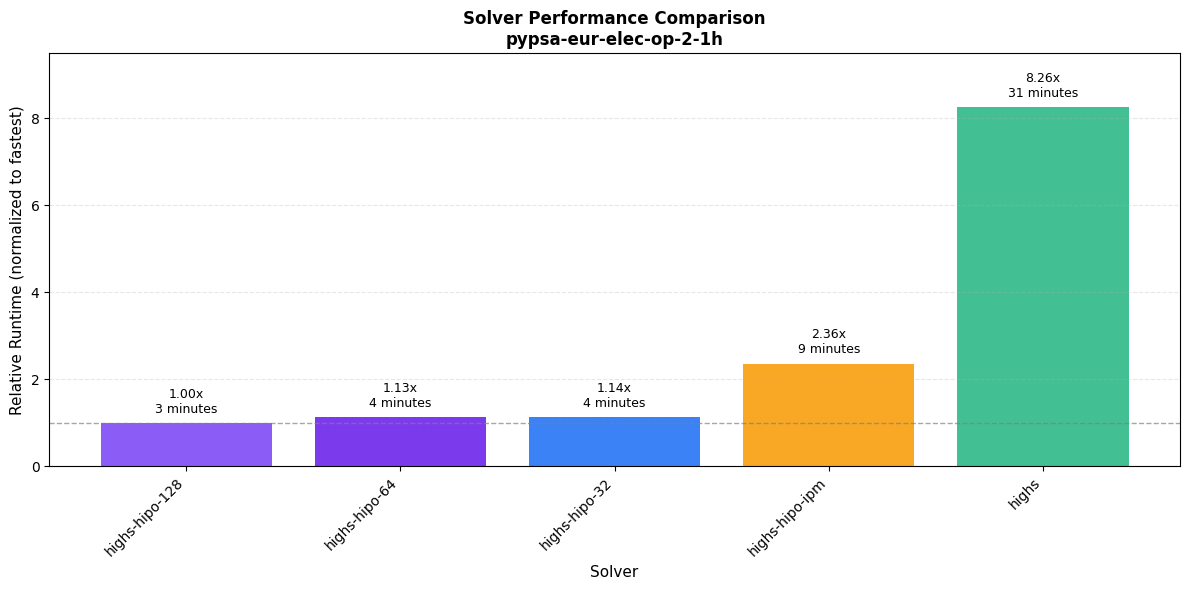


Benchmark: pypsa-eur-elec-op-4-3h
Paper results - IPX (baseline): 484.1s, HiPO: 116.7s, Speedup: 4.15x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 4.44x, Diff vs paper: +0.29x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.59x, Diff vs paper: +0.44x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 4.51x, Diff vs paper: +0.36x (better)



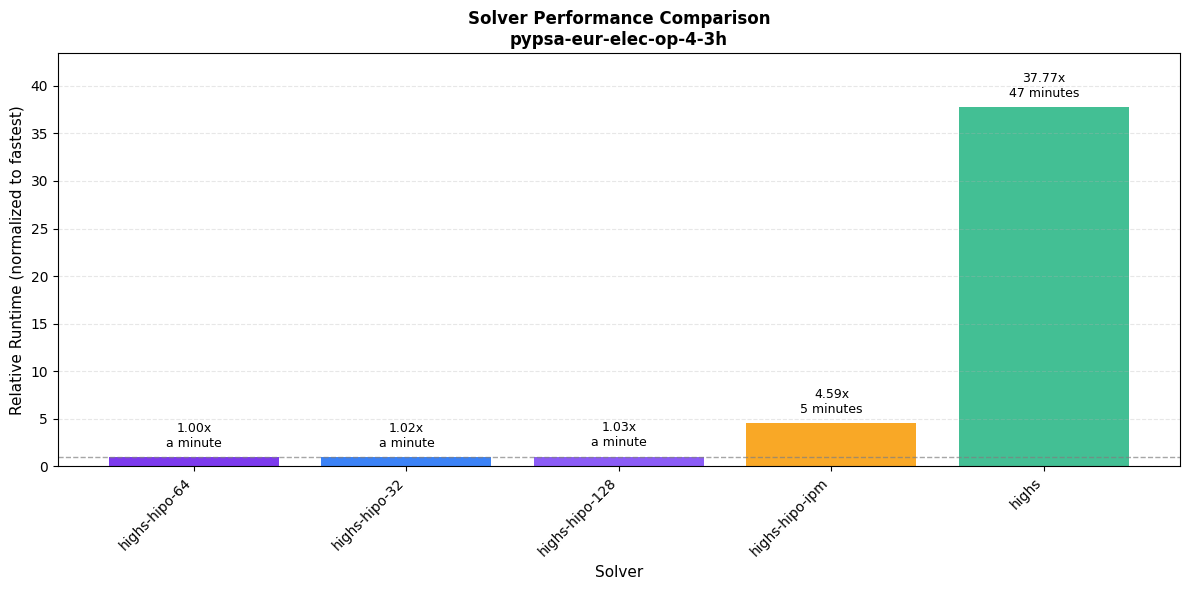


Benchmark: pypsa-eur-elec-op-6-24h
Paper results - IPX (baseline): 24.5s, HiPO: 27.4s, Speedup: 0.89x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.67x, Diff vs paper: +0.77x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.79x, Diff vs paper: +0.89x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.80x, Diff vs paper: +0.90x (better)



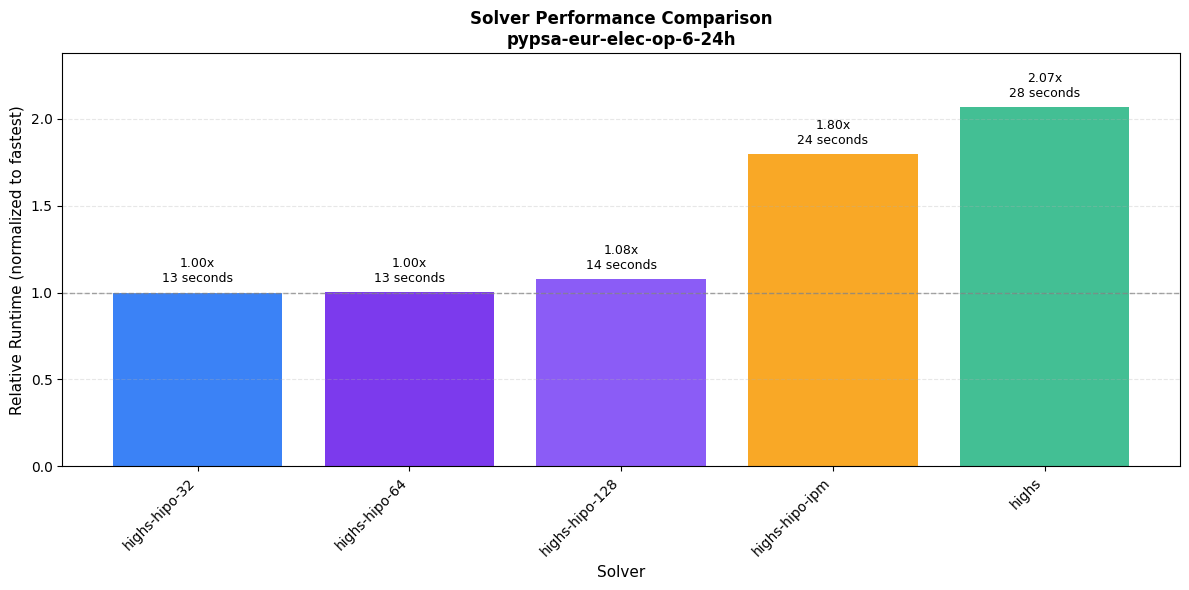


Benchmark: pypsa-eur-elec-op-8-12h
Paper results - IPX (baseline): 164.5s, HiPO: 89.0s, Speedup: 1.85x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.69x, Diff vs paper: -0.16x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.75x, Diff vs paper: -0.10x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.82x, Diff vs paper: -0.03x (worse)



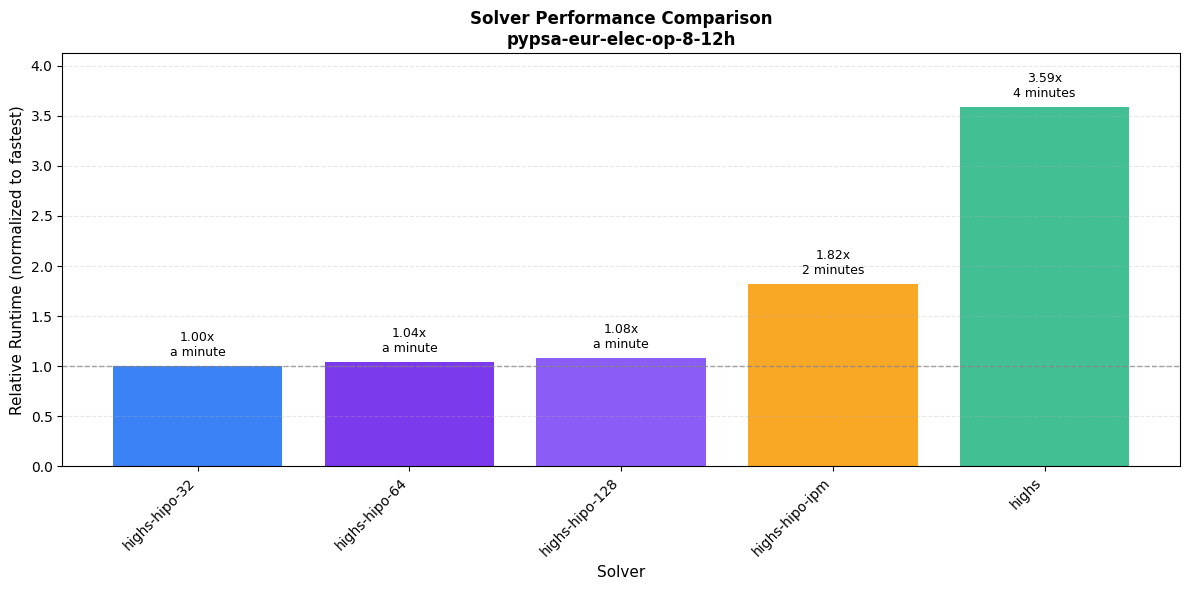


Benchmark: pypsa-eur-elec-trex-3-12h
Paper results - IPX (baseline): 25.6s, HiPO: 39.9s, Speedup: 0.64x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.38x, Diff vs paper: +0.74x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.55x, Diff vs paper: +0.90x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.92x (better)



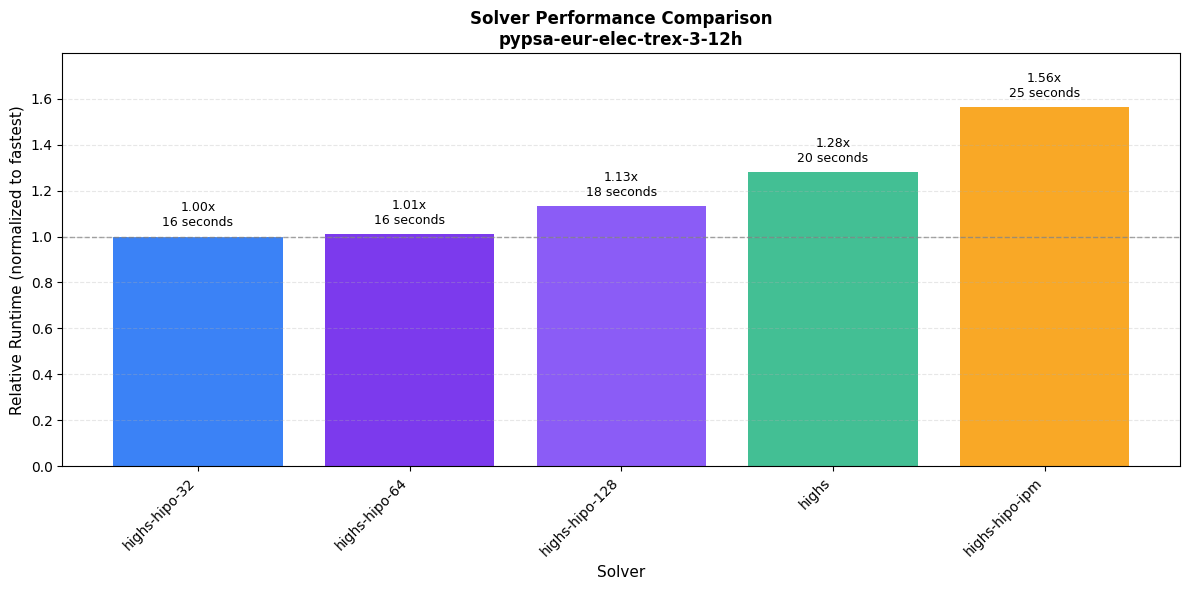


Benchmark: pypsa-eur-elec-trex-3-3h
Paper results - IPX (baseline): 304.1s, HiPO: 87.4s, Speedup: 3.48x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.88x, Diff vs paper: +0.40x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.45x, Diff vs paper: +0.97x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.98x, Diff vs paper: +0.50x (better)



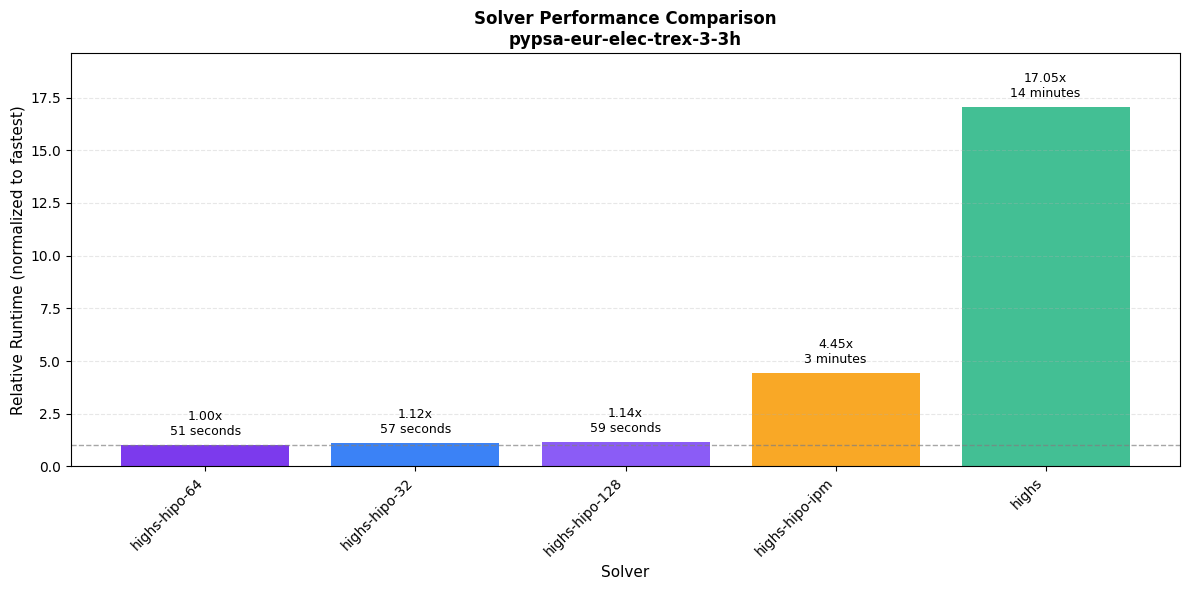


Benchmark: pypsa-eur-elec-trex-4-3h
Paper results - IPX (baseline): 573.2s, HiPO: 131.1s, Speedup: 4.37x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.83x, Diff vs paper: -0.54x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.09x, Diff vs paper: -0.28x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.92x, Diff vs paper: -0.45x (worse)



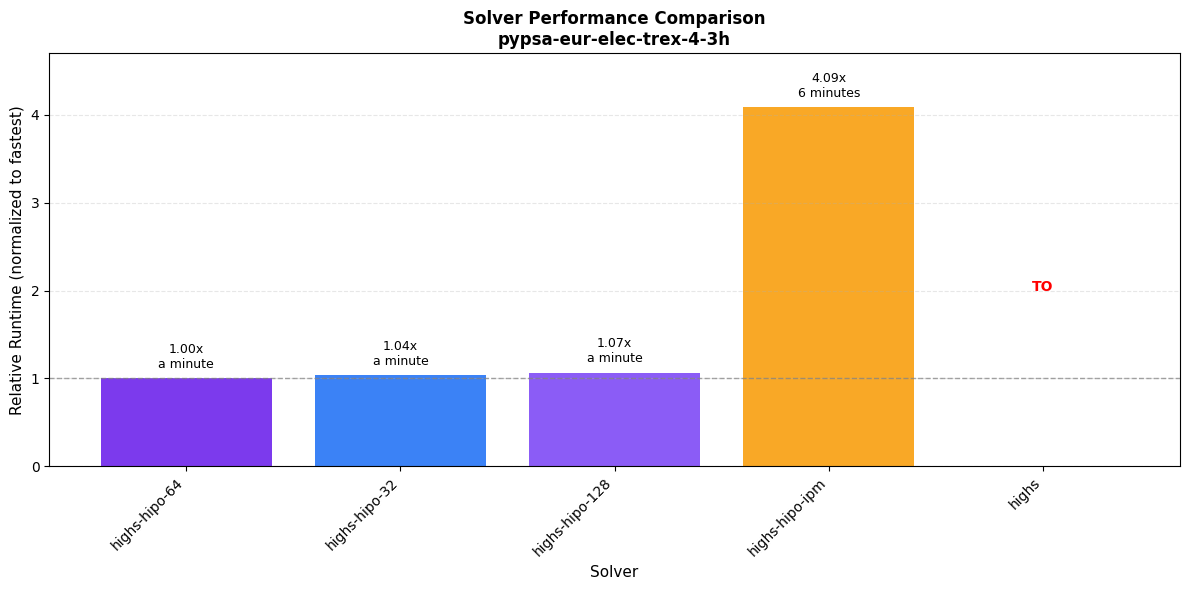


Benchmark: pypsa-eur-elec-trex-6-12h
Paper results - IPX (baseline): 96.7s, HiPO: 78.4s, Speedup: 1.23x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.02x, Diff vs paper: +0.78x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.05x, Diff vs paper: +0.82x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.10x, Diff vs paper: +0.87x (better)



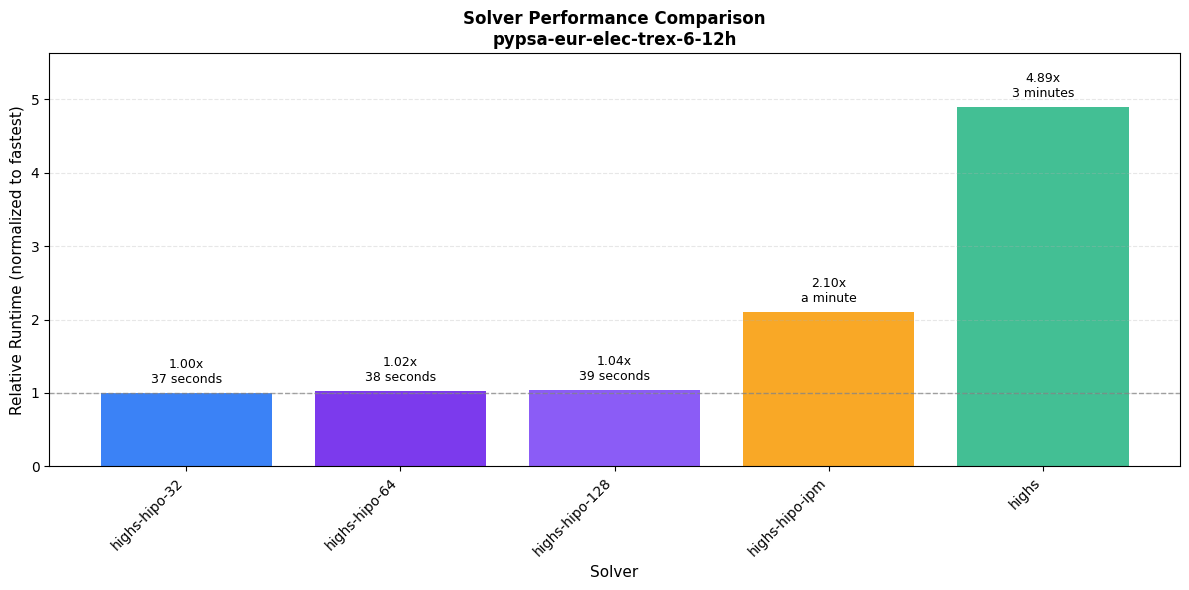


Benchmark: pypsa-eur-sec-2-24h
Paper results - IPX (baseline): 37.9s, HiPO: 29.7s, Speedup: 1.28x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.34x, Diff vs paper: +0.06x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.29x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.47x, Diff vs paper: +0.19x (better)



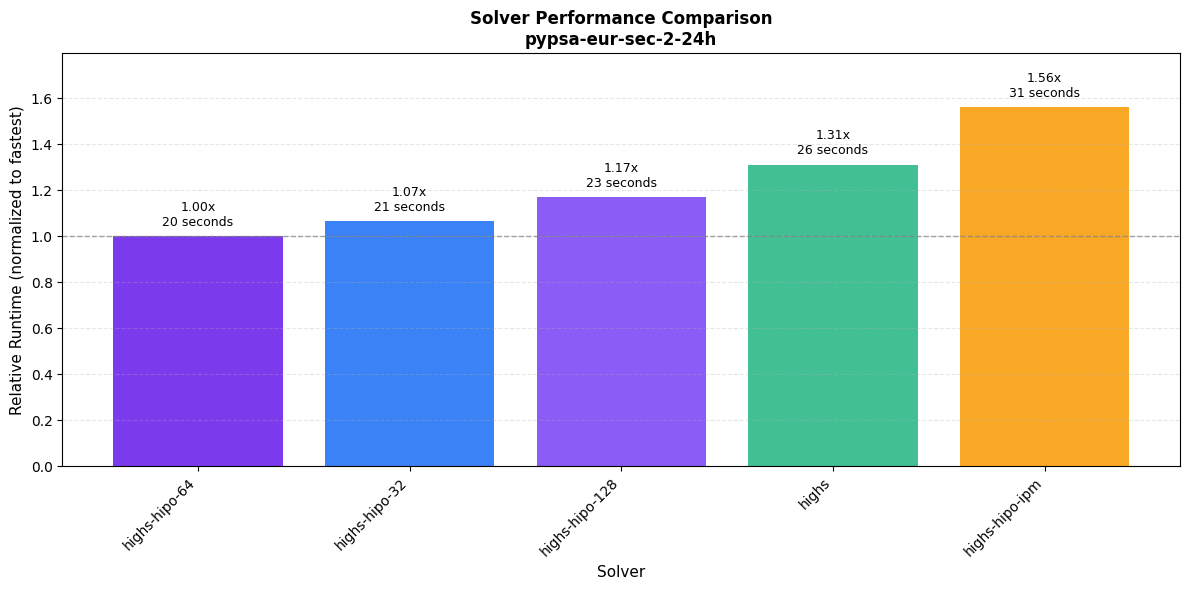

In [ ]:
# HiPO paper results from Table 2: Results on the 45 PyPSA problems
# IPX is the baseline (HiGHS 1.10.0), HiPO is the improved version
hipo_paper_results = {
    # Format: benchmark_name: {"ipx_time": baseline_time, "hipo_time": hipo_time}
    "trex-2-24h": {"ipx_time": 3.1, "hipo_time": 10.4},
    "op-2-24h": {"ipx_time": 2.5, "hipo_time": 7.5},
    "trex-3-24h": {"ipx_time": 7.2, "hipo_time": 14.4},
    "op-3-24h": {"ipx_time": 6.0, "hipo_time": 12.7},
    "trex-2-12h": {"ipx_time": 10.9, "hipo_time": 14.7},
    "op-2-12h": {"ipx_time": 8.9, "hipo_time": 13.4},
    "trex-4-24h": {"ipx_time": 12.5, "hipo_time": 23.3},
    "op-4-24h": {"ipx_time": 11.2, "hipo_time": 20.7},
    "op-5-24h": {"ipx_time": 16.8, "hipo_time": 23.6},
    "trex-5-24h": {"ipx_time": 19.1, "hipo_time": 28.5},
    "trex-3-12h": {"ipx_time": 25.6, "hipo_time": 39.9},
    "op-3-12h": {"ipx_time": 22.4, "hipo_time": 30.5},
    "op-6-24h": {"ipx_time": 24.5, "hipo_time": 27.4},
    "trex-6-24h": {"ipx_time": 25.4, "hipo_time": 34.7},
    "sec-2-24h": {"ipx_time": 37.9, "hipo_time": 29.7},
    "op-7-24h": {"ipx_time": 34.7, "hipo_time": 36.9},
    "trex-7-24h": {"ipx_time": 34.4, "hipo_time": 42.2},
    "op-4-12h": {"ipx_time": 38.2, "hipo_time": 47.3},
    "trex-4-12h": {"ipx_time": 49.2, "hipo_time": 57.4},
    "op-8-24h": {"ipx_time": 40.8, "hipo_time": 37.7},
    "trex-8-24h": {"ipx_time": 43.2, "hipo_time": 46.9},
    "op-9-24h": {"ipx_time": 45.1, "hipo_time": 51.5},
    "trex-9-24h": {"ipx_time": 53.9, "hipo_time": 50.1},
    "trex-10-24h": {"ipx_time": 61.8, "hipo_time": 48.9},
    "op-10-24h": {"ipx_time": 61.9, "hipo_time": 52.9},
    "op-5-12h": {"ipx_time": 64.4, "hipo_time": 52.1},
    "trex-5-12h": {"ipx_time": 64.7, "hipo_time": 65.0},
    "trex-6-12h": {"ipx_time": 96.7, "hipo_time": 78.4},
    "op-6-12h": {"ipx_time": 84.5, "hipo_time": 66.6},
    "trex-2-3h": {"ipx_time": 128.1, "hipo_time": 65.4},
    "op-2-3h": {"ipx_time": 99.7, "hipo_time": 55.6},
    "op-7-12h": {"ipx_time": 129.6, "hipo_time": 84.9},
    "trex-7-12h": {"ipx_time": 137.3, "hipo_time": 86.5},
    "op-8-12h": {"ipx_time": 164.5, "hipo_time": 89.0},
    "trex-8-12h": {"ipx_time": 181.9, "hipo_time": 91.4},
    "op-9-12h": {"ipx_time": 193.2, "hipo_time": 106.4},
    "trex-9-12h": {"ipx_time": 195.0, "hipo_time": 103.1},
    "op-10-12h": {"ipx_time": 251.9, "hipo_time": 109.2},
    "trex-10-12h": {"ipx_time": 284.0, "hipo_time": 111.6},
    "trex-3-3h": {"ipx_time": 304.1, "hipo_time": 87.4},
    "op-3-3h": {"ipx_time": 211.2, "hipo_time": 74.0},
    "trex-4-3h": {"ipx_time": 573.2, "hipo_time": 131.1},
    "op-4-3h": {"ipx_time": 484.1, "hipo_time": 116.7},
    "trex-2-1h": {"ipx_time": 1230.1, "hipo_time": 217.8},
    "op-2-1h": {"ipx_time": 773.2, "hipo_time": 158.4},
}

# Plot each benchmark individually with solvers on x-axis
print("\n" + "="*80)
print("COMPARISON WITH HIPO PAPER RESULTS")
print("="*80)

not_handled_paper_benchmarks = set(hipo_paper_results.keys())

for bench in sorted(unique_benchmarks):
    # if not ('pypsa-eur' in bench and any(suffix in bench for suffix in ['trex', 'sec', 'op'])):
    #     continue
    # paper_bench = bench.replace("pypsa-eur-elec+", "pypsa-eur-elec-").replace("pypsa-eur-elec", "pypsa-eur-elec-")
    # Check if we have paper results for this benchmark
    try:
        k = [b for b in hipo_paper_results.keys() if b in bench]
        if len(k) > 1:
            raise Exception("multiple keys match for bench:", bench, k)
        k = k[0]
        paper_data = hipo_paper_results[k]
        not_handled_paper_benchmarks.remove(k)
    except IndexError:
        # print("not found in paper results:", bench)
        continue

    print(f"\n{'='*80}")
    print(f"Benchmark: {bench}")
    print(f"Paper results - IPX (baseline): {paper_data['ipx_time']:.1f}s, HiPO: {paper_data['hipo_time']:.1f}s, Speedup: {paper_data['ipx_time']/paper_data['hipo_time']:.2f}x")

        # Get our results for comparison
    bench_data = actual_benchmarks[actual_benchmarks['bench-size'] == bench]
    # print(bench_data[['Solver', 'Runtime (s)', 'Status']])
        # Find highs (baseline) and highs-hipo variants
    highs_variants = ['highs', 'highs-hipo-ipm', 'highs-hipo-128', 'highs-hipo-64', 'highs-hipo-32']

    variant_run_times = {}
    for variant in highs_variants:
        variant_time = bench_data[bench_data['Solver'] == variant]['Runtime (s)']
        variant_run_times[variant] = variant_time

    our_speed_ups = {}
    for variant, variant_time in variant_run_times.items():
        if variant in ['highs', 'highs-hipo-ipm']:
            continue
        if not variant_time.empty and variant_run_times['highs-hipo-ipm'].empty == False:
            speed_up = variant_run_times['highs-hipo-ipm'].values[0] / variant_time.values[0] if variant_time.values[0] > 0 else float('inf')
            our_speed_ups[variant] = speed_up
        else:
            print(f"  - Missing data for variant {variant}, cannot compute speedup.")

    # Compare speedups
    paper_speedup = paper_data['ipx_time'] / paper_data['hipo_time']
    for variant, speed_up in our_speed_ups.items():
        speedup_diff = speed_up - paper_speedup
        print(f"Speedup of {variant} vs highs-hipo-ipm: {speed_up:.2f}x, Diff vs paper: {speedup_diff:+.2f}x ({'better' if speedup_diff > 0 else 'worse'})\n")

    print(f"{'='*80}")
    plot_single_benchmark_comparison(results, bench, figsize=(12, 6))
    plt.show()


In [73]:
if not_handled_paper_benchmarks:
    print(f"Warning: Some paper benchmarks not found in results: {not_handled_paper_benchmarks}")
    not_handled_paper_benchmarks.clear()
else:
    print("All paper benchmarks accounted for.")

All paper benchmarks accounted for.



COMPARISON WITH HIPO PAPER RESULTS

Benchmark: pypsa-eur-elec-op-2-1h
Paper results - IPX (baseline): 773.2s, HiPO: 158.4s, Speedup: 4.88x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.36x, Diff vs paper: -2.52x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.09x, Diff vs paper: -2.80x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.08x, Diff vs paper: -2.80x (worse)



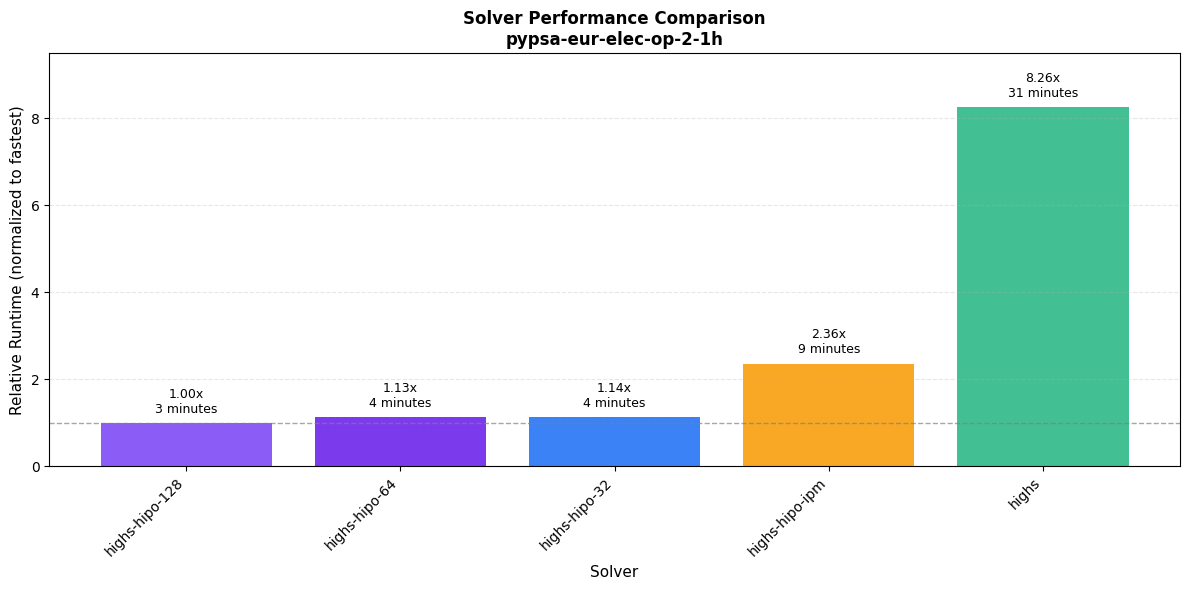


Benchmark: pypsa-eur-elec-op-4-3h
Paper results - IPX (baseline): 484.1s, HiPO: 116.7s, Speedup: 4.15x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 4.44x, Diff vs paper: +0.29x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.59x, Diff vs paper: +0.44x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 4.51x, Diff vs paper: +0.36x (better)



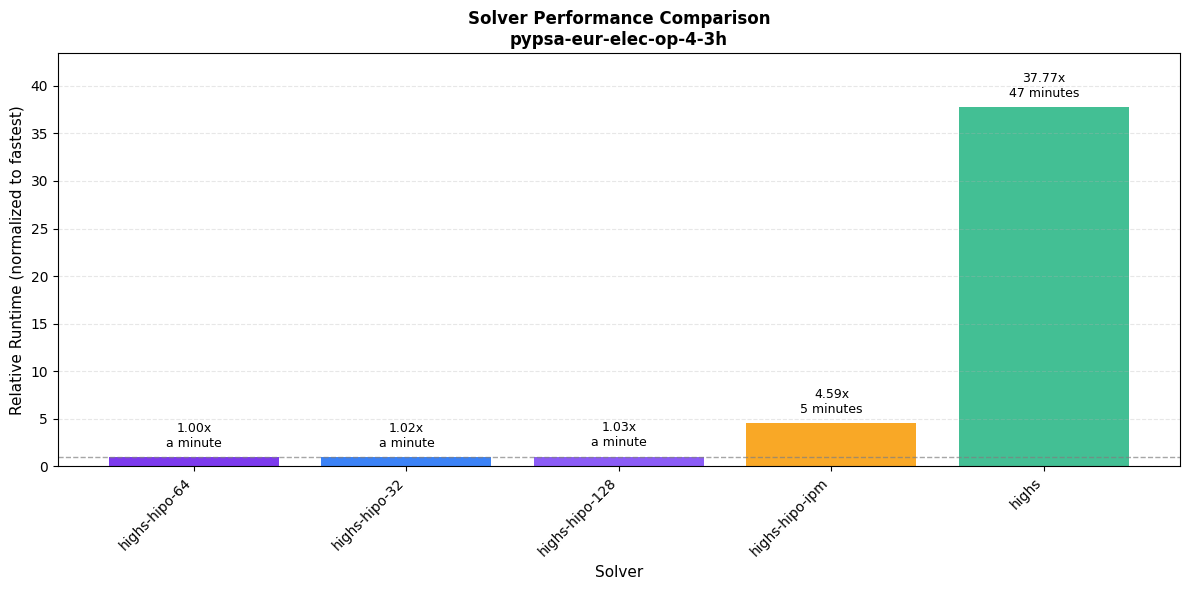


Benchmark: pypsa-eur-elec-op-6-24h
Paper results - IPX (baseline): 24.5s, HiPO: 27.4s, Speedup: 0.89x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.67x, Diff vs paper: +0.77x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.79x, Diff vs paper: +0.89x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.80x, Diff vs paper: +0.90x (better)



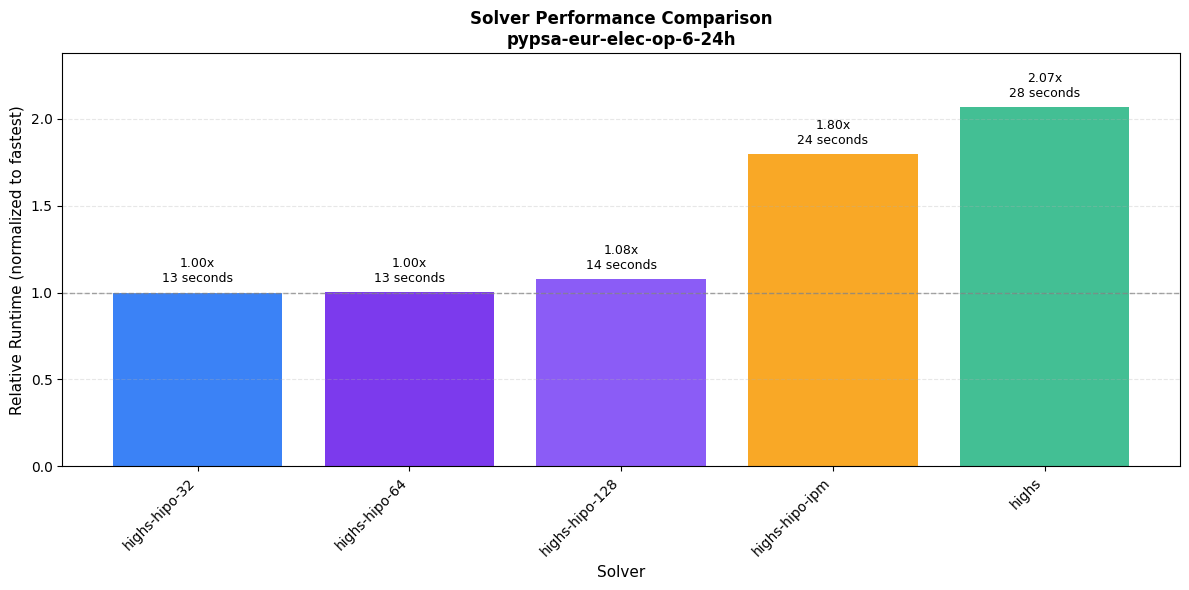


Benchmark: pypsa-eur-elec-op-8-12h
Paper results - IPX (baseline): 164.5s, HiPO: 89.0s, Speedup: 1.85x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.69x, Diff vs paper: -0.16x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.75x, Diff vs paper: -0.10x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.82x, Diff vs paper: -0.03x (worse)



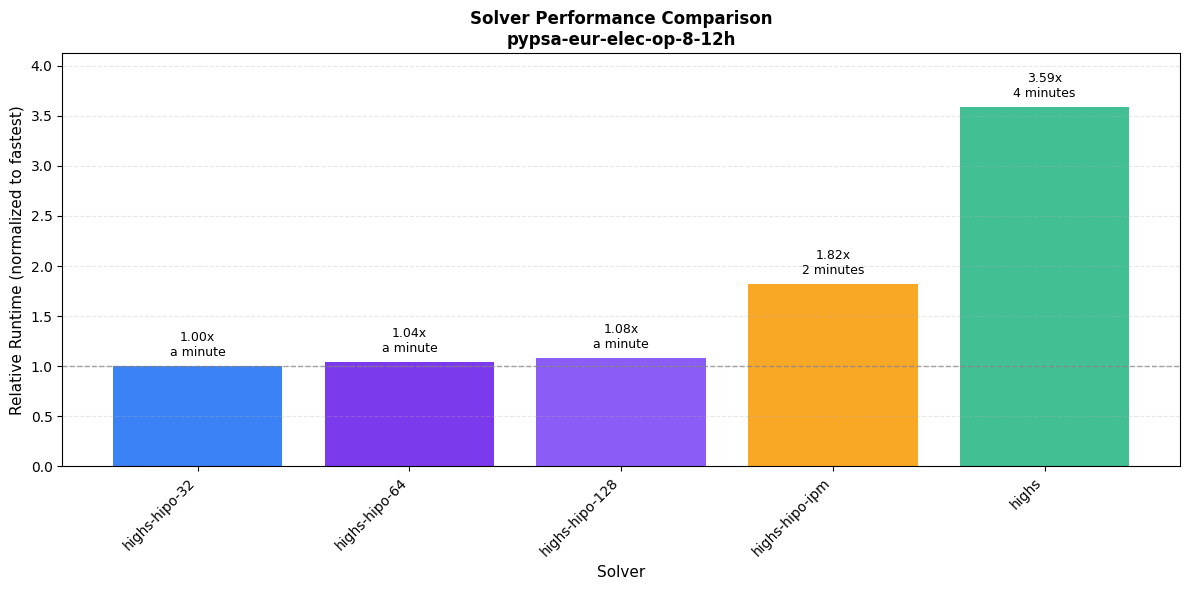


Benchmark: pypsa-eur-elec-trex-3-12h
Paper results - IPX (baseline): 25.6s, HiPO: 39.9s, Speedup: 0.64x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.38x, Diff vs paper: +0.74x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.55x, Diff vs paper: +0.90x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.92x (better)



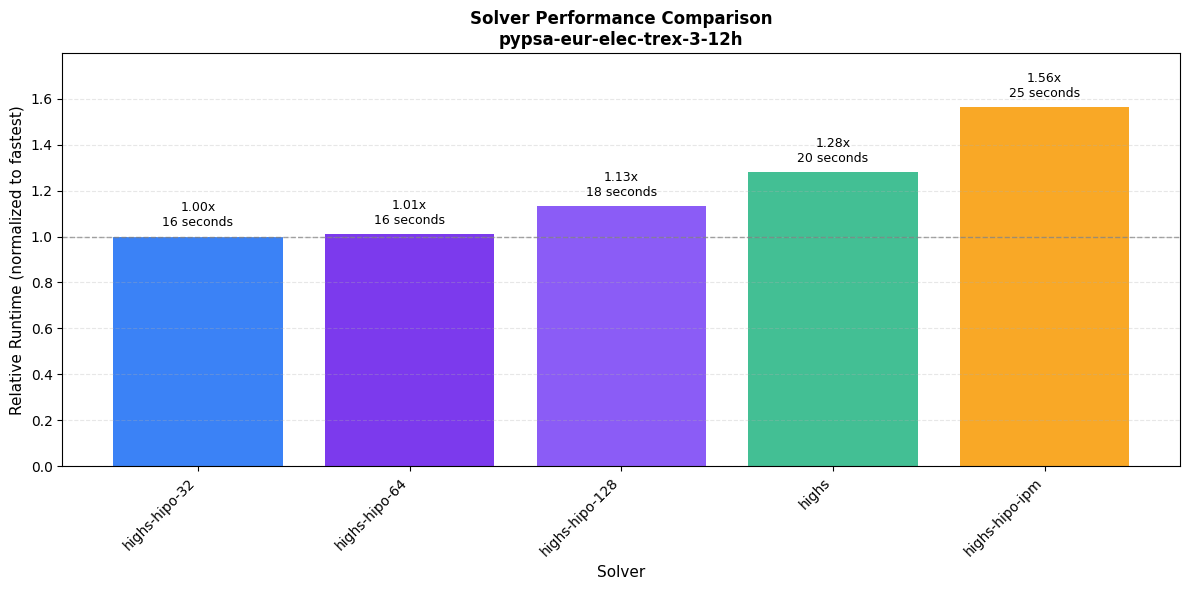


Benchmark: pypsa-eur-elec-trex-3-3h
Paper results - IPX (baseline): 304.1s, HiPO: 87.4s, Speedup: 3.48x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.88x, Diff vs paper: +0.40x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.45x, Diff vs paper: +0.97x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.98x, Diff vs paper: +0.50x (better)



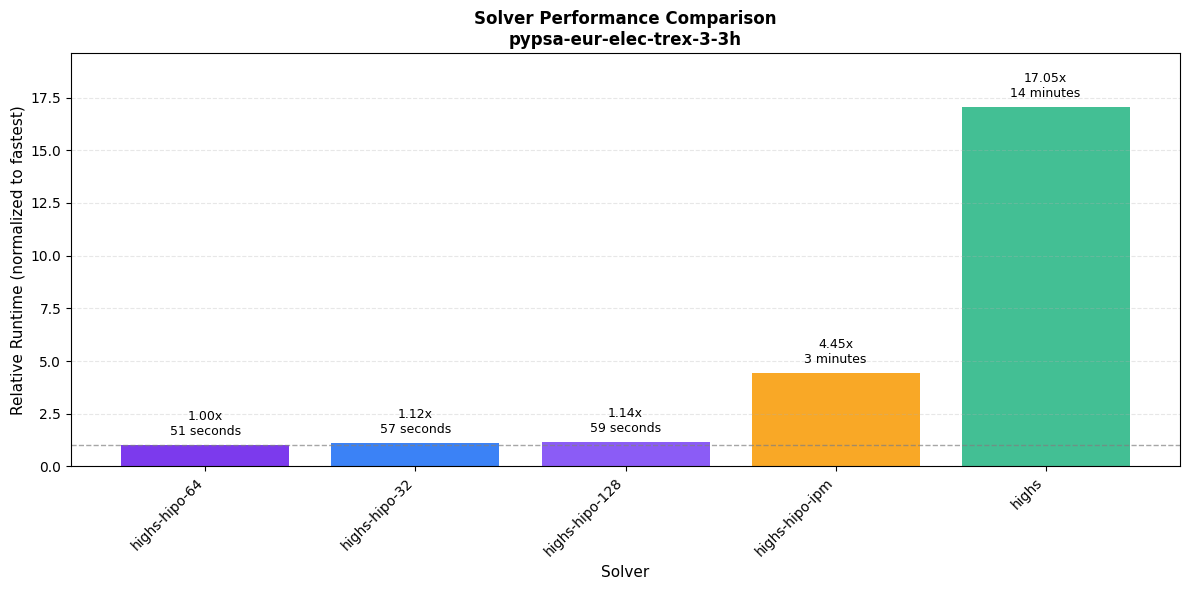


Benchmark: pypsa-eur-elec-trex-4-3h
Paper results - IPX (baseline): 573.2s, HiPO: 131.1s, Speedup: 4.37x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.83x, Diff vs paper: -0.54x (worse)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.09x, Diff vs paper: -0.28x (worse)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.92x, Diff vs paper: -0.45x (worse)



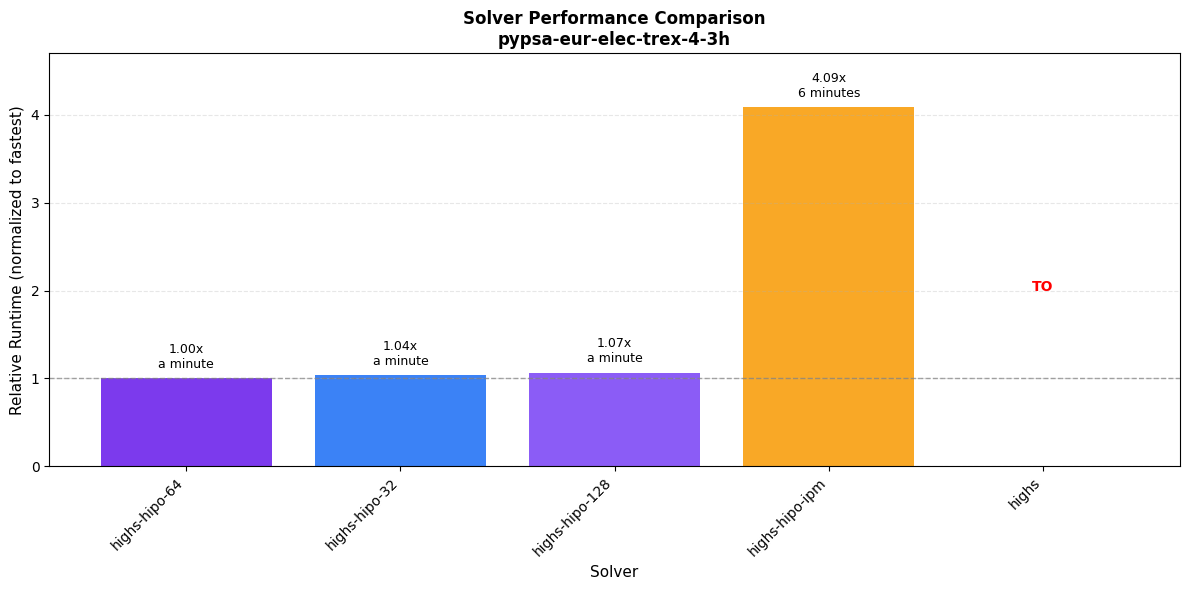


Benchmark: pypsa-eur-elec-trex-6-12h
Paper results - IPX (baseline): 96.7s, HiPO: 78.4s, Speedup: 1.23x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.02x, Diff vs paper: +0.78x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.05x, Diff vs paper: +0.82x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.10x, Diff vs paper: +0.87x (better)



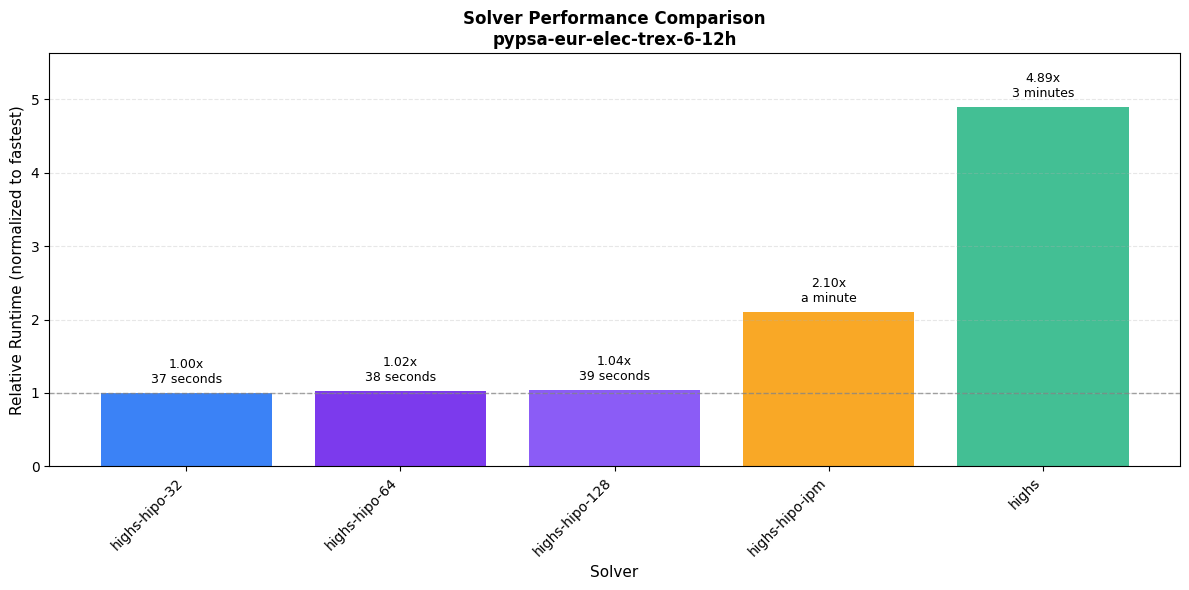


Benchmark: pypsa-eur-sec-2-24h
Paper results - IPX (baseline): 37.9s, HiPO: 29.7s, Speedup: 1.28x
Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.34x, Diff vs paper: +0.06x (better)

Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.29x (better)

Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.47x, Diff vs paper: +0.19x (better)



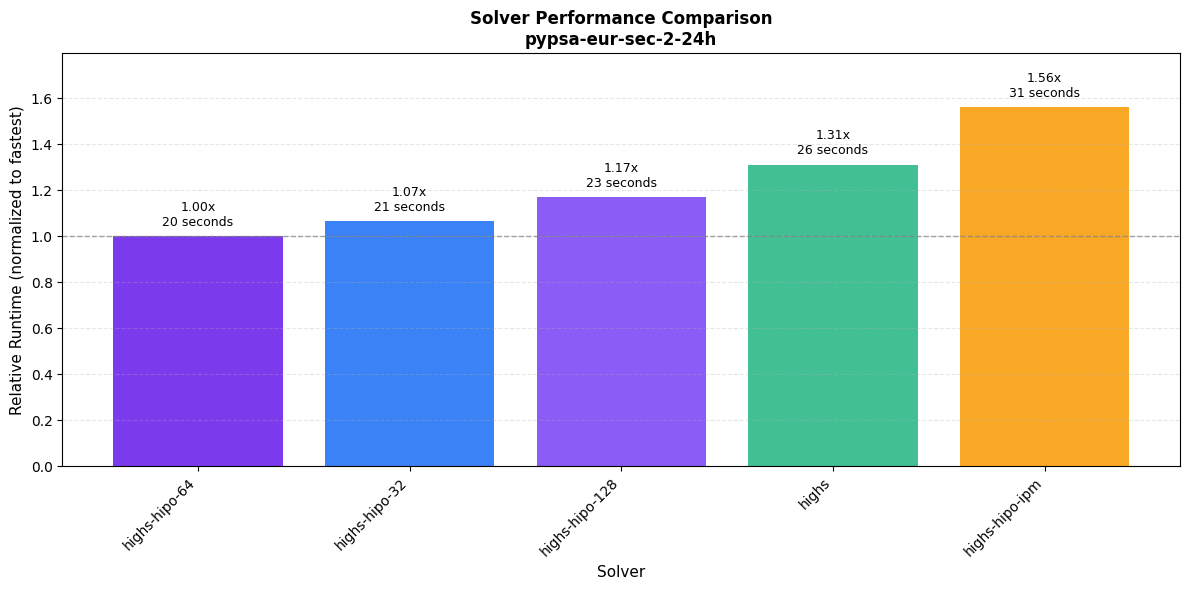

In [76]:
# Plot each benchmark individually with solvers on x-axis
print("\n" + "="*80)
print("COMPARISON WITH HIPO PAPER RESULTS")
print("="*80)

not_handled_paper_benchmarks = set(hipo_paper_results.keys())

for bench in sorted(unique_benchmarks):
    # Check if we have paper results for this benchmark
    try:
        k = [b for b in hipo_paper_results.keys() if b in bench]
        if len(k) > 1:
            raise Exception("multiple keys match for bench:", bench, k)
        k = k[0]
        paper_data = hipo_paper_results[k]
        not_handled_paper_benchmarks.remove(k)
    except IndexError:
        # print("not found in paper results:", bench)
        continue

    print(f"\n{'='*80}")
    print(f"Benchmark: {bench}")
    print(f"Paper results - IPX (baseline): {paper_data['ipx_time']:.1f}s, HiPO: {paper_data['hipo_time']:.1f}s, Speedup: {paper_data['ipx_time']/paper_data['hipo_time']:.2f}x")

    # Get our results and augment with speedup columns
    bench_data = actual_benchmarks[actual_benchmarks['bench-size'] == bench].copy()

    # Get baseline times for speedup calculations
    highs_ipx_time = bench_data[bench_data['Solver'] == 'highs-hipo-ipm']['Runtime (s)'].values
    highs_110_time = bench_data[bench_data['Solver'] == 'highs']['Runtime (s)'].values

    # Initialize speedup columns with NaN
    bench_data['speedup_vs_highs_ipx'] = float('nan')
    bench_data['speedup_vs_highs_110'] = float('nan')

    # Calculate speedups for each solver
    for idx in bench_data.index:
        solver_time = bench_data.loc[idx, 'Runtime (s)']

        # Speedup vs highs-hipo-ipm (IPX baseline)
        if len(highs_ipx_time) > 0 and highs_ipx_time[0] > 0 and solver_time > 0:
            bench_data.loc[idx, 'speedup_vs_highs_ipx'] = highs_ipx_time[0] / solver_time

        # Speedup vs highs (HiGHS 1.10)
        if len(highs_110_time) > 0 and highs_110_time[0] > 0 and solver_time > 0:
            bench_data.loc[idx, 'speedup_vs_highs_110'] = highs_110_time[0] / solver_time

    # Compare speedups for HiGHS HiPO variants
    paper_speedup = paper_data['ipx_time'] / paper_data['hipo_time']

    highs_hipo_variants = ['highs-hipo-128', 'highs-hipo-64', 'highs-hipo-32']
    for variant in highs_hipo_variants:
        variant_data = bench_data[bench_data['Solver'] == variant]
        if not variant_data.empty:
            speedup_ipx = variant_data['speedup_vs_highs_ipx'].values[0]

            if not pd.isna(speedup_ipx):
                speedup_diff = speedup_ipx - paper_speedup
                print(f"Speedup of {variant} vs highs-hipo-ipm: {speedup_ipx:.2f}x, Diff vs paper: {speedup_diff:+.2f}x ({'better' if speedup_diff > 0 else 'worse'})\n")
            else:
                print(f"  - Missing data for variant {variant}, cannot compute speedup.")

    print(f"{'='*80}")
    plot_single_benchmark_comparison(results, bench, figsize=(12, 6))
    plt.show()

## Performance Statistics

In [65]:
# Calculate speedup statistics for each variant compared to baseline highs
baseline_solver = "highs"

# Get baseline runtimes for each benchmark
baseline_data = actual_benchmarks[actual_benchmarks["Solver"] == baseline_solver][
    ["bench-size", "Runtime (s)"]
].rename(columns={"Runtime (s)": "Baseline Runtime"})

# Merge with all results
comparison = actual_benchmarks.merge(baseline_data, on="bench-size", how="left")

# Calculate speedup
comparison["Speedup"] = comparison["Baseline Runtime"] / comparison["Runtime (s)"]

# Summary statistics by solver
speedup_summary = (
    comparison.groupby("Solver")["Speedup"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(3)
)

print("Speedup Statistics (relative to highs 1.10.0):")
print(speedup_summary)

Speedup Statistics (relative to highs 1.10.0):
                 mean  median    min      max     std
Solver                                               
highs           1.000     1.0  1.000    1.000   0.000
highs-hipo-128  4.307     1.0  0.002  184.700  17.753
highs-hipo-32   4.365     1.0  0.006  172.432  16.774
highs-hipo-64   4.413     1.0  0.006  170.458  16.731
highs-hipo-ipm  2.532     1.0  0.002   32.392   4.326


## Memory Usage Comparison

In [66]:
# Memory usage comparison
memory_summary = (
    actual_benchmarks.groupby("Solver")["Memory Usage (MB)"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(2)
)

print("Memory Usage Statistics (MB):")
print(memory_summary)

Memory Usage Statistics (MB):
                   mean  median     min       max      std
Solver                                                    
highs           2364.20  893.13  144.15  22340.72  4239.29
highs-hipo-128  2260.74  339.25  136.64  43677.21  6223.68
highs-hipo-32   1898.26  336.37  136.24  37552.31  4886.77
highs-hipo-64   1913.10  337.82  136.46  37557.16  4898.60
highs-hipo-ipm  1050.57  221.54  136.27  37553.36  3631.96


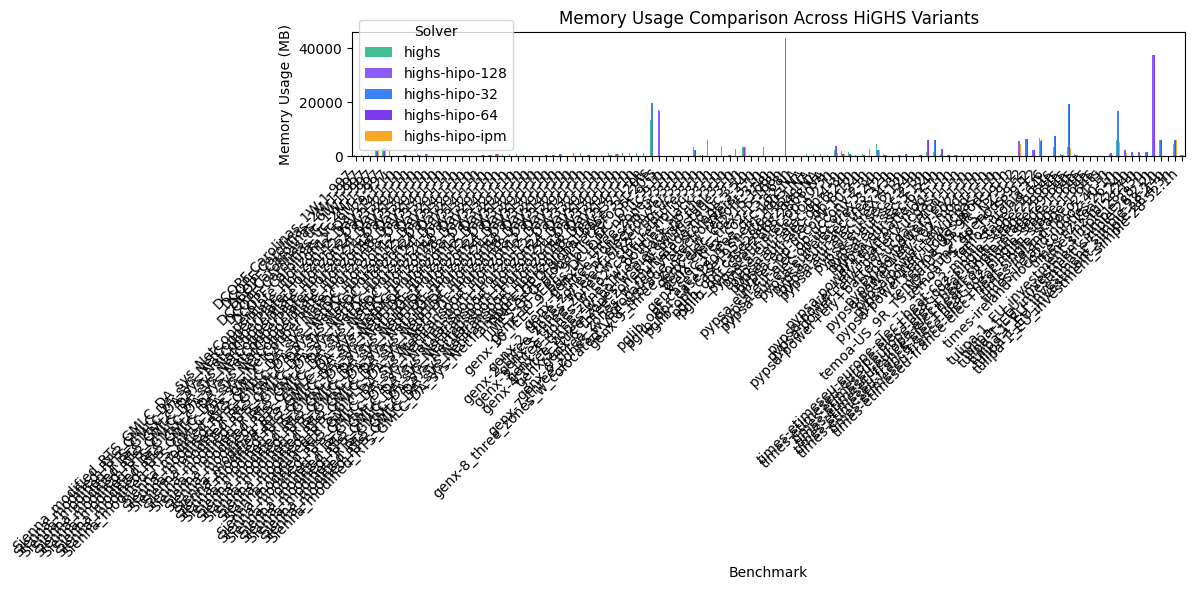

In [67]:
# Plot memory usage comparison
fig, ax = plt.subplots(figsize=(12, 6))

pivot_memory = actual_benchmarks.pivot_table(
    index="bench-size", columns="Solver", values="Memory Usage (MB)", aggfunc="mean"
)

pivot_memory.plot(kind="bar", ax=ax, color=[color_map.get(s, "#888888") for s in pivot_memory.columns])
ax.set_ylabel("Memory Usage (MB)")
ax.set_xlabel("Benchmark")
ax.set_title("Memory Usage Comparison Across HiGHS Variants")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Runtime vs Memory Trade-off

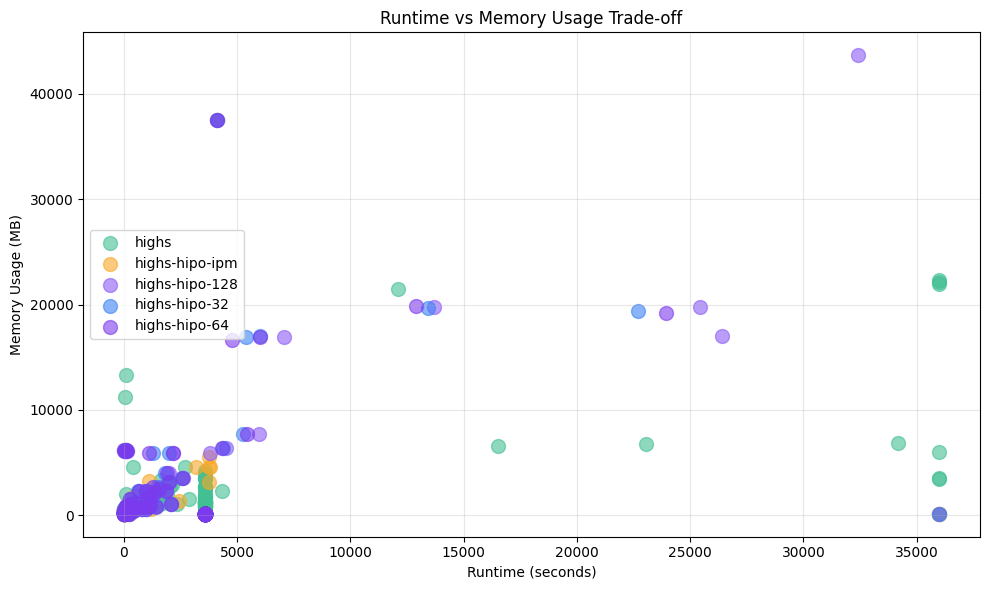

In [68]:
# Scatter plot: runtime vs memory usage
fig, ax = plt.subplots(figsize=(10, 6))

for solver in actual_benchmarks["Solver"].unique():
    solver_data = actual_benchmarks[actual_benchmarks["Solver"] == solver]
    ax.scatter(
        solver_data["Runtime (s)"],
        solver_data["Memory Usage (MB)"],
        label=solver,
        alpha=0.6,
        s=100,
        color=color_map.get(solver, "#888888"),
    )

ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("Memory Usage (MB)")
ax.set_title("Runtime vs Memory Usage Trade-off")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Benchmark-by-Benchmark Analysis

In [69]:
# For each benchmark, show detailed comparison
for bench in sorted(unique_benchmarks):
    bench_data = actual_benchmarks[actual_benchmarks["bench-size"] == bench]

    print(f"\n{'=' * 80}")
    print(f"Benchmark: {bench}")
    print(f"{'=' * 80}")

    # Create summary table
    summary = bench_data[["Solver", "Runtime (s)", "Memory Usage (MB)", "Status"]].copy()
    summary = summary.sort_values("Runtime (s)")

    # Calculate speedup relative to baseline
    baseline_runtime = bench_data[bench_data["Solver"] == baseline_solver][
        "Runtime (s)"
    ].values
    if len(baseline_runtime) > 0:
        summary["Speedup vs highs"] = baseline_runtime[0] / summary["Runtime (s)"]
        summary["Speedup vs highs"] = summary["Speedup vs highs"].round(3)

    print(summary.to_string(index=False))
    print()


Benchmark: DCOPF-Carolinas_1W-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs     9.580801            624.612     ok             1.000
highs-hipo-ipm    10.867961            280.208     ok             0.882
 highs-hipo-32    16.550848            338.920     ok             0.579
highs-hipo-128    30.337095            341.236     ok             0.316
 highs-hipo-64    30.387234            342.176     ok             0.315


Benchmark: DCOPF-Carolinas_2M-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs    10.932277            621.916     ok             1.000
 highs-hipo-32    11.936978            338.400     ok             0.916
highs-hipo-ipm    12.335830            278.288     ok             0.886
 highs-hipo-64    20.097734            339.676     ok             0.544
highs-hipo-128    20.252379            339.252     ok             0.540


Benchmark: DCOPF-Carolinas_6M-1-997
        Solver  Runtime

## Reference Benchmark Consistency Check

Reference benchmark runs: 233

Runtime statistics:
count    233.000000
mean     196.161353
std       18.045095
min      179.824185
25%      181.866021
50%      186.131995
75%      214.136851
max      239.270748
Name: Runtime (s), dtype: float64

Coefficient of Variation: 0.0920
⚠ Moderate consistency (5% <= CV < 10%)


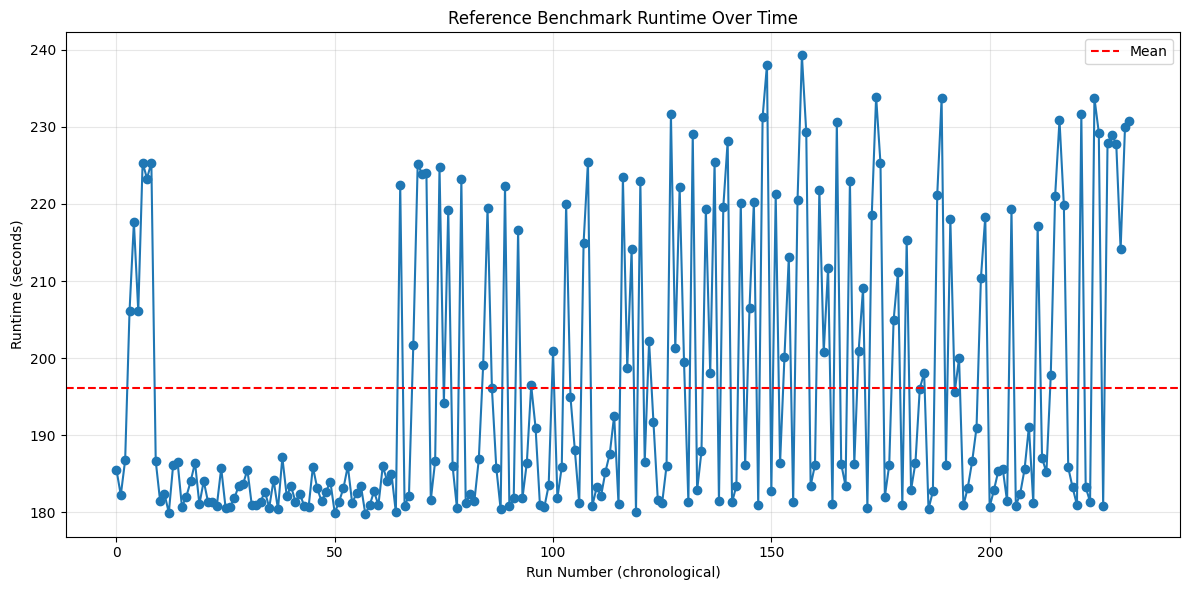

In [70]:
# Analyze reference benchmark to ensure consistent machine performance
reference_results = results[results["Benchmark"] == "reference-benchmark"].copy()

if len(reference_results) > 0:
    print(f"Reference benchmark runs: {len(reference_results)}")
    print(f"\nRuntime statistics:")
    print(reference_results["Runtime (s)"].describe())

    # Check coefficient of variation
    cv = (
        reference_results["Runtime (s)"].std() / reference_results["Runtime (s)"].mean()
    )
    print(f"\nCoefficient of Variation: {cv:.4f}")
    if cv < 0.05:
        print("✓ Good consistency (CV < 5%)")
    elif cv < 0.10:
        print("⚠ Moderate consistency (5% <= CV < 10%)")
    else:
        print("✗ Poor consistency (CV >= 10%)")

    # Plot reference benchmark over time
    fig, ax = plt.subplots(figsize=(12, 6))
    reference_sorted = reference_results.sort_values("Timestamp")
    ax.plot(range(len(reference_sorted)), reference_sorted["Runtime (s)"], "o-")
    ax.axhline(
        reference_sorted["Runtime (s)"].mean(),
        color="red",
        linestyle="--",
        label="Mean",
    )
    ax.set_xlabel("Run Number (chronological)")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_title("Reference Benchmark Runtime Over Time")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No reference benchmark results found.")

## Key Findings Summary

In [71]:
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# 1. Best overall variant
avg_runtimes = actual_benchmarks.groupby("Solver")["Runtime (s)"].mean().sort_values()
print(f"\n1. Average Runtime Ranking:")
for i, (solver, runtime) in enumerate(avg_runtimes.items(), 1):
    print(f"   {i}. {solver}: {runtime:.2f}s")

# 2. Best speedup
print(f"\n2. Best Average Speedup vs {baseline_solver}:")
speedup_by_solver = (
    comparison[comparison["Solver"] != baseline_solver]
    .groupby("Solver")["Speedup"]
    .mean()
    .sort_values(ascending=False)
)
for solver, speedup in speedup_by_solver.items():
    print(f"   {solver}: {speedup:.3f}x")

# 3. Memory efficiency
print(f"\n3. Average Memory Usage:")
avg_memory = actual_benchmarks.groupby("Solver")["Memory Usage (MB)"].mean().sort_values()
for solver, memory in avg_memory.items():
    print(f"   {solver}: {memory:.2f} MB")

# 4. Success rate
print(f"\n4. Success Rate:")
success_rate = (
    actual_benchmarks.groupby("Solver")["Status"]
    .apply(lambda x: (x == "ok").sum() / len(x) * 100)
    .sort_values(ascending=False)
)
for solver, rate in success_rate.items():
    print(f"   {solver}: {rate:.1f}%")


KEY FINDINGS

1. Average Runtime Ranking:
   1. highs-hipo-64: 1669.84s
   2. highs-hipo-32: 1963.57s
   3. highs-hipo-128: 2474.53s
   4. highs-hipo-ipm: 2539.87s
   5. highs: 3933.16s

2. Best Average Speedup vs highs:
   highs-hipo-64: 4.413x
   highs-hipo-32: 4.365x
   highs-hipo-128: 4.307x
   highs-hipo-ipm: 2.532x

3. Average Memory Usage:
   highs-hipo-ipm: 1050.57 MB
   highs-hipo-32: 1898.26 MB
   highs-hipo-64: 1913.10 MB
   highs-hipo-128: 2260.74 MB
   highs: 2364.20 MB

4. Success Rate:
   highs-hipo-64: 73.0%
   highs-hipo-128: 72.6%
   highs-hipo-32: 72.4%
   highs-hipo-ipm: 70.9%
   highs: 63.6%
